In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
import re
import requests
import pickle
import os
from google.cloud import bigquery
import io
import PIL
tqdm.pandas()
%load_ext google.cloud.bigquery
import plotly.graph_objects as go
import datetime

with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

In [2]:
plt.rc('font', family='sans-serif') 

## Vehicle Type & Geography variables

In [3]:
# Phase out this bit. 
lad_code='K02000001'
geography_name = 'United Kingdom'
bodyType = 'Cars'
geography_abbreviation = 'UK'

## Step 1: Pre-process data

### 1.1 Fuel Consumption Data

The Department for Business, Energy Security and Industrial Strategy (as was) publishes sub-national fuel consumption data, from which we can extract data for the UK. Unfortunately they publish one year on one tab of the document, meaning we need to write a little script to extract the data and put it in a better format. 

Input: 'sub-national-road-transport-fuel-consumption-statistics-2005-20**.ods' from inside the `data` folder, available at https://www.gov.uk/government/collections/road-transport-consumption-at-regional-and-local-level 

Output: a CSV file with cleaned up fuel consumption data, where each row is a year, so that we can see the trend over time. The csv `yearly_fuel_consumption.csv` is saved in the `data` folder. 

In [4]:
if not os.path.isfile('data/uk_yearly_fuel.csv'.format(geography_abbreviation.lower())):

    years = list(range(2005, 2021))
    years = [str(x) for x in years]

    fl = []

    for year in tqdm(years):
        df = pd.read_excel('data/sub-national-road-transport-fuel-consumption-statistics-2005-2020.ods', header=3, sheet_name=year)
        df = df[df['Local Authority Code'] == lad_code]
        df['year'] = int(year)
        fl.append(df)

    fc = pd.concat(fl)

    fc.set_index('year', inplace=True)

    fc.index = pd.to_datetime(fc.index, format='%Y')

    fc.to_csv('data/uk_yearly_fuel.csv'.format(lad_code))
else:
    fc = pd.read_csv('data/uk_yearly_fuel.csv'.format(geography_abbreviation.lower()), index_col=0)
    fc.index = pd.to_datetime(fc.index)

### 1.2 Vehicle Fleet Composition Data

We want to know how many cars are on the road in the UK. DfT publishes two tables which cover this, from their Vehicle Licensing Statistics data series (here: https://www.gov.uk/government/statistical-data-sets/vehicle-licensing-statistics-data-tables). 

The two tables are VEH0105 and VEH0142 covering the number of petrol, diesel and other fossil fuelled vehicles, and different kinds of low emissions vehicles respectively. Because these are in two different sheets, we need a script (below) that will clean them up and make them more usable. It's very slow, unfortunately. 

Inputs: 'veh0105.ods' and 'veh0142' from the `data` folder. They are saved into one CSV called `vehicle_parc.csv`



In [5]:
def ft_cleaner_dft(x):
    x = x.replace('Battery electric', 'Pure Electric')
    x = x.replace('Other fuels', 'Other').replace('Other fuel types', 'Other')
    x = x.replace('Plug-in hybrid electric (diesel)', 'Diesel')
    x = x.replace('Range extended electric', 'Pure Electric')
    x = x.replace('Plug-in hybrid electric (petrol)', 'Hybrid')
    x = x.replace('Hybrid electric (petrol)', 'Hybrid')
    x = x.replace('Hybrid electric (diesel)', 'Diesel')
    x = x.replace('Fuel cell electric', 'Pure Electric')
    x = x.replace('Gas', 'Other')
    return x

def ft_cleaner(x):
    x = x.replace('GAS BI-FUEL', 'Other').replace('GAS', 'Other').replace('GAS DIESEL', 'Other').replace('PETROL/GAS', 'Other').replace('LPG', 'Other').replace('STEAM', 'Other').replace('LNG', 'Other').replace('OTHER', 'Other').replace('CNG', 'Other')
    x = x.replace('FUEL CELLS', 'Other')
    x = x.replace('PETROL', 'Petrol').replace('Petrol/Other', 'Petrol')
    x = x.replace('HYBRID ELECTRIC (CLEAN)', 'Hybrid').replace('HYBRID ELECTRIC', 'Hybrid').replace('ELECTRIC DIESEL', 'Hybrid')
    x = x.replace('DIESEL', 'Diesel').replace('Other Diesel', 'Diesel')
    x = x.replace('ELECTRICITY', 'Pure Electric').replace('ELECTRIC', 'Pure Electric')
    return x

In [6]:
if not os.path.isfile('data/uk_vehicle_parc.csv'):

    # This deals with VEH0105. We're basically taking the ODS format document, and then dropping irrelevant bits of the table. Unfortunately as DfT like to change the way they format their spreadsheets, this will likely break in the future or need amendment to keep it working OK. 

    veh0105 = pd.read_excel('data/veh0105.ods', sheet_name='VEH0105', header=4)
    veh0105.drop(columns=['Units', 'ONS Geography [note 6]'], inplace=True)
    veh0105 = veh0105[veh0105.BodyType != 'Total']
    veh0105 = veh0105[veh0105['Fuel [note 2]'] != 'Total']
    veh0105 = veh0105[veh0105['Keepership [note 3]'] != 'Total']
    veh0105 = veh0105[veh0105['ONS Code [note 6]'] == lad_code]
    veh0105.drop(columns=['ONS Sort [note 6]', 'ONS Code [note 6]'], inplace=True)
    veh0105.rename(columns={'Fuel [note 2]': 'Fuel', 'Keepership [note 3]': 'Keepership'}, inplace=True)
    veh0105 = veh0105.melt(id_vars=['BodyType', 'Fuel', 'Keepership'])
    veh0105['value'] = veh0105.value.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    veh0105['variable'] = pd.PeriodIndex(veh0105['variable'].apply(lambda x: x.replace(' ', '-')), freq='Q').to_timestamp()
    veh0105['value'] = veh0105['value'].apply(lambda x: x*1000)
    
    # Now import VEH0142
    veh0142 = pd.read_excel('data/veh0142.ods', sheet_name='VEH0142', header=4)
    veh0142.drop(columns=['Units', 'ONS Geography [note 6]'], inplace=True)
    veh0142 = veh0142[veh0142['Fuel'] != 'Total']
    veh0142 = veh0142[veh0142['BodyType'] != 'Total']
    veh0142 = veh0142[veh0142['Keepership [note 3]'] != 'Total']
    veh0142 = veh0142[veh0142['ONS Code [note 6]'] == lad_code]
    veh0142.drop(columns=['ONS Sort [note 6]', 'ONS Code [note 6]'], inplace=True)
    veh0142.rename(columns={'Fuel [note 2]': 'Fuel', 'Keepership [note 3]': 'Keepership'}, inplace=True)
    veh0142 = veh0142.melt(id_vars=['Fuel', 'Keepership', 'BodyType'])
    veh0142['value'] = veh0142.value.apply(lambda x: pd.to_numeric(x, errors='coerce'))
    veh0142['variable'] = pd.PeriodIndex(veh0142['variable'].apply(lambda x: x.replace(' ', '-')), freq='Q').to_timestamp()
    
    pc = pd.concat([veh0142, veh0105])
    pc['variable'] = pc.variable.apply(pd.to_datetime)
    pc = pc.groupby(['variable', 'BodyType', 'Fuel']).sum().reset_index(['BodyType', 'Fuel'])
    pc['Fuel'] = pc.Fuel.apply(ft_cleaner_dft)
    pc = pc.reset_index().groupby(['variable', 'BodyType', 'Fuel']).sum().reset_index(['BodyType', 'Fuel'])
    
    pc.to_csv('data/uk_vehicle_parc.csv')
    
else:
    pc = pd.read_csv('data/uk_vehicle_parc.csv', index_col=0)
    pc.index = pd.to_datetime(pc.index)

In [7]:
cars = pc[pc.BodyType == bodyType].pivot(columns='Fuel', values='value').resample('YS').last()

### 1.3 Average vehicle Milaege

We want to know how annual mileage is changing in UK. This was calculated using a query 'Annual Welsh Car Mileage by Fueltype', which is saved in BigQuery. That query essentially takes a selection of vehicles that have had an MOT in a Welsh postcode district, and then calculates its annual mileage, which is then allocated to a year (imperfectly). Lastly, we group them by a particular set of fueltypes (Petrol, Diesel and Electric, with hybrids grouped into Petrol) and the mean is calculated. 

A note on this. Why do we take the mean? We want to know things about the total demand for vehicle miles (perhaps) more than the behaviour of particular outliers. Knowing the total number of vehicles and the average mileage gives us a good indication of this. It may limit our ability to consider how targeting high miler vehicles might accelerate the transition, but there will be some possibility to consider a reduction in the average mileage driven by fossil fuel. Also, the MOT database does not give us a complete picture of the whole vehicle parc, since it misses young vehicles. So using it a bit like a survey, taking the mean, and using that in conjunction with the total number of vehicles, seems like it could be a sensible approach. 

In [8]:
mm = pd.read_csv('data/cars_average_mileage.csv')
mm['year'] = pd.to_datetime(mm.year, format='%Y')

In [9]:
mm.fuelType.unique()

array(['Petrol', 'Pure electric', 'Diesel', 'Hybrid', 'Other'],
      dtype=object)

In [10]:
mm = mm.set_index('year').pivot(columns='fuelType', values='annual_mileage').resample('YS').first()
mm = mm[mm.index>'2006-12-31']

In [11]:
mm.rename(columns={
    'Diesel': 'diesel_mileage',
    'Hybrid': 'hybrid_mileage',
    'Other': 'other_ft_mileage',
    'Petrol': 'petrol_mileage',
    'Pure electric': 'electric_mileage'
}, inplace=True)

### 1.4 Traffic Data

This gets GB data unless a valid region code is specified. LAD-level data is available from DfT, too, from a different endpoint. 

In [12]:
# r = requests.get('https://roadtraffic.dft.gov.uk/api/regions')
# ons_codes = []
# id_codes = []


# for x in r.json():
#     ons_codes.append(x['ons_code'])
#     id_codes.append(x['id'])
    
# region_dict = dict(zip(id_codes, ons_codes))

# try:
#     url = 'https://roadtraffic.dft.gov.uk/api/traffic/regions/vehicle-type?filter[region_id]={}'.format(region_dict[lad_code])
#     r = requests.get(url)
#     tra = pd.DataFrame(r.json()['data'])
#     tra['year'] = tra.year.apply(lambda x: pd.to_datetime(x, format='%Y'))

#     tra.set_index('year', inplace=True)
#     tra = tra.resample('YS').last()
#     tra = tra.drop(columns=['id', 'region_id', 'ons_code', 'total_link_length_km', 'total_link_length_miles'])
    
# except:
    
#     url = 'https://roadtraffic.dft.gov.uk/api/charts/traffic/annual/vehicle-type'
#     r = requests.get(url)
#     new_data = []
#     idx = []
#     names = []


#     data = r.json()

#     for d in data:
#         idx = [x[0] for x in d['data']]
#         names.append(d['id'])
#         new_data.append([x[1] for x in d['data']])

#     tra = pd.DataFrame(index=names, columns=idx, data=new_data).T
#     tra.index = pd.to_datetime(tra.index, format='%Y')
#     tra = tra.resample('Y').last()
#     tra = tra *1000000000

In [13]:
# r = requests.get('https://roadtraffic.dft.gov.uk/api/traffic/regions/vehicle-type?filter[region_id]=4')
# # r = requests.get(url)
# tra = pd.DataFrame(r.json()['data'])
# tra['year'] = tra.year.apply(lambda x: pd.to_datetime(x, format='%Y'))

# tra.set_index('year', inplace=True)
# tra = tra.resample('Y').last()
# tra = tra.drop(columns=['id', 'region_id', 'ons_code', 'total_link_length_km', 'total_link_length_miles'])

### 1.5 Vehicle Additions

We use VEH1153 to get newly registered vehicles, supplemented with our own data on Northern Irish registrations, since the DfT's UK-wide data only goes back to 2014, with older time periods only including GB-wide data. 

In [14]:
# nrg = pd.read_excel('data/veh1153.ods', sheet_name='VEH1153a_RoadUsing', header=4)
# nrg.columns = [re.sub('\[note \d\]', '', x) for x in nrg.columns]
# nrg.columns = [x.strip() for x in nrg.columns]

# ecc = nrg[
#     (nrg.Geography == 'Wales') &
#     (nrg['Date Interval'] == 'Monthly') &
#     (nrg.Units == "Thousands") &
#     (nrg.BodyType == "Cars")
# ]

# ecc['Date'] = ecc['Date'].apply(pd.to_datetime)

# # ecc = ecc.set_index('Date')

# ecc = ecc.drop(columns=['Total', 'Plug-in', 'Zero emission'])


# ecc = ecc.melt(id_vars=['Date', 'Geography', 'Date Interval', 'Units', 'BodyType'], value_vars=ecc.columns[5:]).rename(columns={'variable': 'fuelType'})

# ecc['fuelType'] = ecc.fuelType.apply(ft_cleaner_dft)
# ecc = ecc.groupby(['Date', 'fuelType']).sum().reset_index(['fuelType']).pivot(columns='fuelType').resample('Y').sum()
# ecc.columns = [x[1] for x in ecc.columns]
# ecc = 1000*ecc

# ecc.to_csv('data/new_registrations.csv')

In [15]:
if not os.path.isfile('data/new_registrations.csv'):

    nrg = pd.read_excel('data/veh1153.ods', sheet_name='VEH1153a_RoadUsing', header=4)
    nrg.columns = [re.sub('\[note \d\]', '', x) for x in nrg.columns]
    nrg.columns = [x.strip() for x in nrg.columns]
    
    nrg.to_csv('data/new_registrations.csv')
else:
    nrg = pd.read_csv('data/new_registrations.csv', index_col=0)

if geography_name == 'United Kingdom':
    geography_name_adj ='Great Britain'
else:
    geography_name_adj = geography_name

ecc = nrg[
    (nrg.Geography == geography_name_adj) &
    (nrg['Date Interval'] == 'Monthly') &
    (nrg.Units == "Thousands") &
    (nrg.BodyType == bodyType)
]

ecc['Date'] = ecc['Date'].apply(pd.to_datetime)

# ecc = ecc.set_index('Date')

ecc = ecc.drop(columns=['Total', 'Plug-in', 'Zero emission'])


ecc = ecc.melt(id_vars=['Date', 'Geography', 'Date Interval', 'Units', 'BodyType'], value_vars=ecc.columns[5:]).rename(columns={'variable': 'fuelType'})

ecc['fuelType'] = ecc.fuelType.apply(ft_cleaner_dft)
ecc = ecc.drop(columns=['Geography', 'Date Interval', 'Units', 'BodyType']).groupby(['Date', 'fuelType']).sum().reset_index(['fuelType']).pivot(columns='fuelType').resample('YS').sum()
ecc.columns = [x[1] for x in ecc.columns]
ecc = 1000*ecc

<ipython-input-15-8eee7569603c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecc['Date'] = ecc['Date'].apply(pd.to_datetime)


In [16]:
ecc

Diesel    Hybrid   Other     Petrol  Pure Electric
Date                                                             
2001-01-01   460649.0     632.0  2112.0  2122507.0           82.0
2002-01-01   636794.0     285.0  2501.0  2042486.0           65.0
2003-01-01   728257.0     377.0  3234.0  1914145.0           43.0
2004-01-01   847024.0    1555.0  1850.0  1748557.0           93.0
2005-01-01   893665.0    5374.0   542.0  1543643.0          231.0
2006-01-01   892669.0    8843.0   139.0  1438068.0          324.0
2007-01-01   955965.0   15882.0   272.0  1417511.0          450.0
2008-01-01   913240.0   15266.0   216.0  1183055.0          221.0
2009-01-01   815458.0   14460.0   266.0  1137886.0          182.0
2010-01-01   913139.0   21820.0   232.0  1060877.0          256.0
2011-01-01   958565.0   23017.0   113.0   924507.0         1209.0
2012-01-01  1017228.0   23630.0    80.0   967689.0         2198.0
2013-01-01  1105490.0   25957.0    28.0  1090596.0         3011.0
2014-01-01  1216509.0   40108.0    39.0  1173681.0         8003.0
2015-01-01  1257148.0   57330.0    50.0  1276075.0        11543.0
2016-01-01  1264518.0   75166.0    34.0  1313345.0        12188.0
2017-01-01  1049086.0  101880.0    17.0  1342152.0        16195.0
2018-01-01   736172.0  127679.0    99.0  1459789.0        17766.0
2019-01-01   606975.0  140511.0    38.0  1509952.0        37933.0
2020-01-01   315467.0  210068.0   776.0   986852.0       106794.0
2021-01-01   223460.0  335034.0  2316.0   891232.0       188182.0
2022-01-01   119924.0  293792.0  2324.0   617293.0       172819.0

In [17]:
# %%bigquery ni --project rugged-baton-283921
# SELECT monthOfFirstRegistration, fuelType, COUNT(*) as total
# FROM VES_dataset.VRN_UK
# WHERE typeApproval = 'N1'
# AND region='NI'
# AND fuelType IS NOT NULL
# AND monthOfFirstRegistration > '2000-12-31'
# AND monthOfFirstRegistration < '2022-12-31'
# GROUP BY monthOfFirstRegistration, fuelType

In [18]:
# Since we miss out Northern Ireland registrations, we pull in data on new car registrations from our own database to supplement the DfT statistics. 
ni = pd.read_csv('data/ni_new_cars.csv')

In [19]:
ni['fuelType'] = ni.fuelType.apply(ft_cleaner)
niw = ni.groupby(['monthOfFirstRegistration', 'fuelType']).sum().reset_index('fuelType').pivot(columns='fuelType', values='total')
niw.index = pd.to_datetime(niw.index, utc=None)
niw.index = niw.index.tz_localize(None)
niw = niw.resample('YS').last()


In [20]:
ecc = (ecc + niw)

<AxesSubplot:xlabel='Date'>

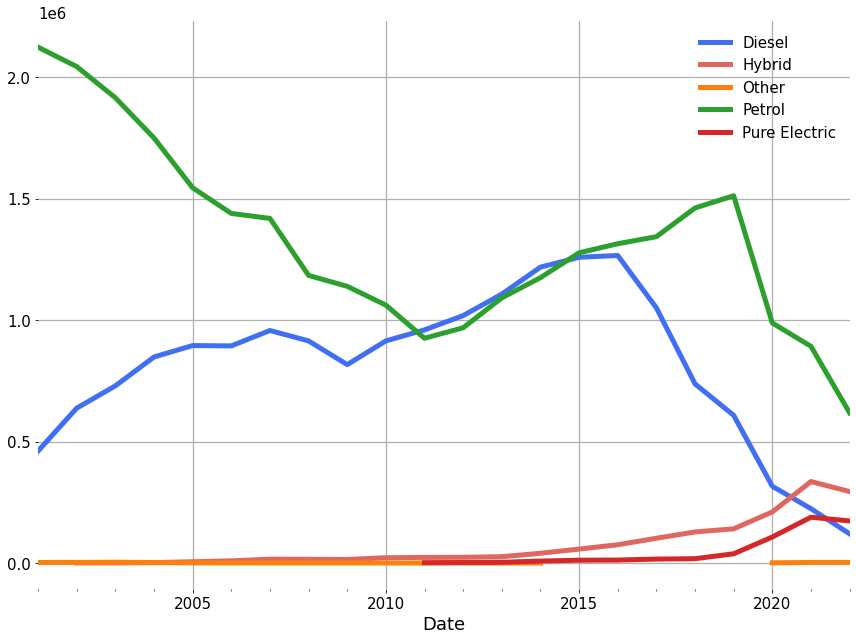

In [21]:
ecc.plot()

### 1.6 UK emissions

This is really what we are trying to estimate. The National Atmospheric Emissions Inventory tots up total territorial emissions, and publishes them. 

In [22]:
em = pd.read_excel('data/2209201114_DA_GHGI_1990-2020_Final_v4.1_AR4_AR5.xlsm', sheet_name='{} By Source_AR5'.format(geography_abbreviation), header=16, usecols='B:AC')
em['NCFormat'] = em.NCFormat.fillna(method='ffill')
em = em.melt(id_vars=['NCFormat', 'IPCC_name'])
em = em[em.variable != 'BaseYear']
em['variable']=em['variable'].apply(pd.to_datetime)
emt = em[em.NCFormat == 'Transport']
emt = emt.pivot(index='variable', columns='IPCC_name', values='value')
# emt.T.sort_values('2019-01-01', ascending=False)[['2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01']]

# emt.to_csv('outputs/transport_subsectors.csv')

In [23]:
emt.columns.tolist()

['1A3a_Domestic_aviation',
 '1A3bi_Cars',
 '1A3bii_Light_duty_trucks',
 '1A3biii_Heavy_duty_trucks_and_buses',
 '1A3biv_Motorcycles',
 '1A3bv_Other_road_transport',
 '1A3c_Railways',
 '1A3d_Domestic_navigation',
 '1A3eii_Other_Transportation',
 '1A4ai_Commercial/Institutional',
 '1A4ciii_Fishing',
 '1A5b_Other:Mobile',
 '2D1_Lubricant_Use',
 '2D3_Non-energy_products_from_fuels_and_solvent_use:Other']

# Part 2: Modelling and Estimating: Cars

The drivers of emissions are many and become quickly complicated. We'll start with the number of vehicles, annual mileage, fuel consumption, calculate fuel economy, and then create a simple way of plugging in fleet, mileage, and consumption numbers to get an emissions estimate. 

We'll load all these inputs into one dataframe, `df`. 

### 2.1 Car Parc & Miles Driven

In [24]:
# Create a DataFrame to hold our data

df = cars.merge(mm, how='left', left_index=True, right_index=True)
df = df[df.index > '2013-12-31']

In [25]:
# calculate total VMT by fuel type

df['diesel_vmt'] = df.apply(lambda row: row['Diesel'] * row['diesel_mileage'], axis=1)
df['petrol_vmt'] = df.apply(lambda row: row['Petrol'] * row['petrol_mileage'], axis=1)
df['electric_vmt'] = df.apply(lambda row: row['Pure Electric'] * row['electric_mileage'], axis=1)
df['hybrid_vmt'] = df.apply(lambda row: row['Hybrid'] * row['hybrid_mileage'], axis=1)

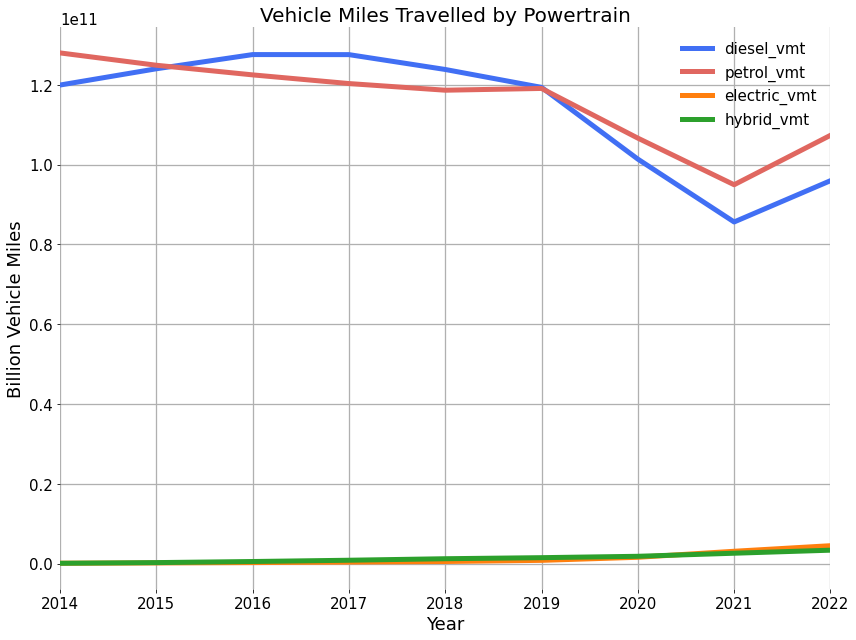

In [26]:
fig, ax = plt.subplots()

df[['diesel_vmt', 'petrol_vmt', 'electric_vmt', 'hybrid_vmt']].plot(ax=ax)
ax.set_title('Vehicle Miles Travelled by Powertrain')
ax.set_ylabel('Billion Vehicle Miles')
ax.set_xlabel('Year')

plt.show()

### 2.2 Adding in fuel consumption

In [27]:
# fc[['Diesel cars total', 'Petrol cars total']].rename(columns={
#     'Diesel cars total': 'car_diesel_consumption',
#     'Petrol cars total': 'car_petrol_consumption'
# }).resample('YS').last()

In [28]:
df = df.merge(fc[['Diesel cars total', 'Petrol cars total']].rename(columns={
    'Diesel cars total': 'car_diesel_consumption',
    'Petrol cars total': 'car_petrol_consumption'
}).resample('YS').last(),
        how='left',
        left_index=True,
        right_index=True)

In [29]:
# Calculate the amount of petrol that's consumed by pure petrol cars and hybrid cars. 
# On average, hybrids have 0.7 times the WLTP co2/km rating of petrol cars, so we'll use that as a very rough way of working out their fuel consumption
df['pure_petrol_share'] = df.apply(lambda row: row['petrol_vmt'] / (row['hybrid_vmt']*.7 + row['petrol_vmt']), axis=1)
df['hybrid_petrol_share'] = df.pure_petrol_share.apply(lambda x: 1-x)

In [30]:
df

Diesel    Hybrid      Other      Petrol  Pure Electric  \
variable                                                                 
2014-01-01  10968863.0    7232.0   246560.0  18739719.0        14328.0   
2015-01-01  11651974.0   22988.0   308603.0  18574731.0        24451.0   
2016-01-01  12296229.0   47909.0   386247.0  18492246.0        34488.0   
2017-01-01  12615832.0   76282.0   490230.0  18423529.0        48907.0   
2018-01-01  12662139.0  112966.0   619006.0  18568990.0        64881.0   
2019-01-01  12567953.0  140534.0   778526.0  18894394.0        99473.0   
2020-01-01  12255205.0  195529.0  1084319.0  18792569.0       201678.0   
2021-01-01  11884303.0  296492.0  1630489.0  18723197.0       384077.0   
2022-01-01  11698381.0  344658.0  1969425.0  18814210.0       496082.0   

            diesel_mileage  hybrid_mileage  other_ft_mileage  petrol_mileage  \
variable                                                                       
2014-01-01    10936.202744    10562.156377      10736.490969     6830.794536   
2015-01-01    10644.794975    10716.697489      10484.035654     6725.032887   
2016-01-01    10376.604466    10857.634603      10127.260827     6624.450468   
2017-01-01    10112.599653    10998.586613       9936.503505     6531.131889   
2018-01-01     9781.636033    10790.694828       9935.565102     6390.194843   
2019-01-01     9498.001392    10561.817871      10344.429713     6303.511363   
2020-01-01     8273.260261     9350.317254       9315.795845     5675.050270   
2021-01-01     7205.456602     8754.267393       8157.842332     5072.091349   
2022-01-01     8203.917407     9744.769186       9691.168302     5705.614549   

            electric_mileage    diesel_vmt    petrol_vmt  electric_vmt  \
variable                                                                 
2014-01-01       6132.168427  1.199577e+11  1.280072e+11  8.786171e+07   
2015-01-01       6928.237950  1.240329e+11  1.249157e+11  1.694023e+08   
2016-01-01       7308.252598  1.275931e+11  1.225010e+11  2.520470e+08   
2017-01-01       7795.994137  1.275789e+11  1.203265e+11  3.812787e+08   
2018-01-01       8108.767237  1.238564e+11  1.186595e+11  5.261049e+08   
2019-01-01       8139.812848  1.193704e+11  1.191010e+11  8.096916e+08   
2020-01-01       7840.222633  1.013905e+11  1.066488e+11  1.581200e+09   
2021-01-01       8039.995988  8.563183e+10  9.496577e+10  3.087978e+09   
2022-01-01       9033.500161  9.597255e+10  1.073466e+11  4.481357e+09   

              hybrid_vmt  car_diesel_consumption  car_petrol_consumption  \
variable                                                                   
2014-01-01  7.638551e+07            11488.015627            13773.047113   
2015-01-01  2.463554e+08            11963.987815            13542.083897   
2016-01-01  5.201784e+08            12359.981823            13484.611966   
2017-01-01  8.389942e+08            12744.117762            13405.659155   
2018-01-01  1.218982e+09            12777.842575            13495.598961   
2019-01-01  1.484295e+09            12927.770762            13719.339782   
2020-01-01  1.828258e+09             9533.463574            10577.458968   
2021-01-01  2.595570e+09                     NaN                     NaN   
2022-01-01  3.358613e+09                     NaN                     NaN   

            pure_petrol_share  hybrid_petrol_share  
variable                                            
2014-01-01           0.999582             0.000418  
2015-01-01           0.998621             0.001379  
2016-01-01           0.997036             0.002964  
2017-01-01           0.995143             0.004857  
2018-01-01           0.992860             0.007140  
2019-01-01           0.991352             0.008648  
2020-01-01           0.988142             0.011858  
2021-01-01           0.981227             0.018773  
2022-01-01           0.978568             0.021432

In [31]:
df['petrol_car_petrol_consumption'] = df.apply(lambda row: row['car_petrol_consumption'] * row['pure_petrol_share'], axis=1)
df['hybrid_car_petrol_consumption'] = df.apply(lambda row: row['car_petrol_consumption'] * row['hybrid_petrol_share'], axis=1)

Petrol and diesel consumption are currently in kilotonnes of oil equivalent. Let's do some processing to make them into something a bit nicer - gallons. 

We're going to multiply petrol and diesel consumption by 1000 to get tonnes of oil equivalent. Then to get to something a bit nicer, we'll use conversion factors from Eurostat (https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Tonnes_of_oil_equivalent_(toe)) to get cubic metres, then from that we can convert them to gallons and calculate MPG. 



In [32]:
df['car_diesel_consumption_gallons'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)/.98) * 219.969)

# NB that petrol has a different conversion factor. Tonnes of oil equivalent is essentially the energy content of the fuel, and diesel is more energy-dense. 
df['car_petrol_consumption_gallons'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)/.86) * 219.969)
df['petrol_car_petrol_consumption_gallons'] = df.petrol_car_petrol_consumption.apply(lambda x: ((1000*x)/.86) * 219.969)
df['hybrid_car_petrol_consumption_gallons'] = df.hybrid_car_petrol_consumption.apply(lambda x: ((1000*x)/.86) * 219.969)


In [33]:
# df['hybrid_petrol_consumption_gallons'] = df.car_petrol_consumption_gallons.apply(lambda x: x*hybrid_fuel_factor)
# df['petrol_petrol_consumption_gallons'] = df.apply(lambda row: row['car_petrol_consumption_gallons'] - row['hybrid_petrol_consumption_gallons'], axis=1)

Now calculate fuel economy. 

In [34]:
df['pure_petrol_economy'] = df.apply(lambda row: row['petrol_vmt'] / row['petrol_car_petrol_consumption_gallons'] , axis=1)
df['diesel_economy'] = df.apply(lambda row: row['diesel_vmt'] / row['car_diesel_consumption_gallons'], axis=1)
df['hybrid_economy'] = df.apply(lambda row: row['hybrid_vmt'] / row['hybrid_car_petrol_consumption_gallons'] , axis=1)
df['petrol_economy'] = df.apply(lambda row: (row['hybrid_vmt'] + row['petrol_vmt']) / row['car_petrol_consumption_gallons'] , axis=1)

<AxesSubplot:xlabel='variable'>

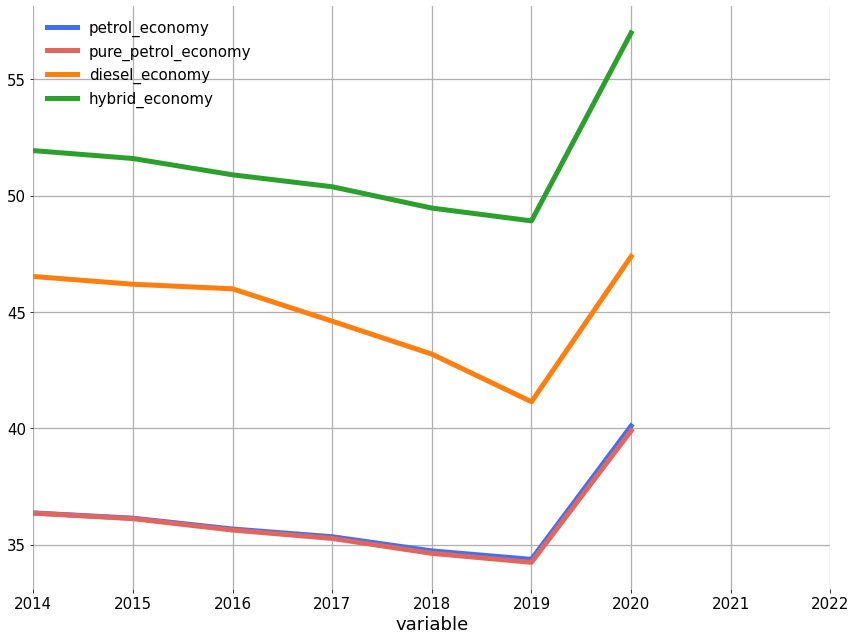

In [35]:
# fig, ax = plt.subplots(figsize=(12, 8))

df[['petrol_economy', 'pure_petrol_economy', 'diesel_economy', 'hybrid_economy']].plot()
# ax.set_title('Calculated Car Fuel Economy')
# ax.set_ylabel('Miles Per Gallon')
# ax.set_xlabel('Year')

# # ax.text(x=50, y=40, s='Large increase in\nfuel economy could \nbe due to less traffic \nduring lockdowns.')

# plt.show()

### 2.3 Calculate Emissions from Fuel Consumption

The first step here is to convert toe diesel and petrol consumption to an estimation of CO2e, using a conversion factor available from the government. This is the UK government's preferred emission factor for businesses and government departments. They are available here: https://www.gov.uk/government/publications/greenhouse-gas-reporting-conversion-factors-2022

To make this calculations, we multiply fuel consumption by 1000 to get the toe, then we convert the toe to kwh, then we convert the kwh to kgCO2e using a conversion factor from the spreadsheet above. 

The conversion factors used are:
* Petrol - 'Petrol average biofuel blend' - kWh (Gross CV) - .22719
* Diesel - 'Diesel average biofuel blend' - kWh (Gross CV) - .24115

In [36]:
# It seems the govt put out different factors every year. Not sure why this would change. 
# # Conversion factors from 2021
# df['diesel_emissions'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.23686)
# df['petrol_emissions'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22980)

# # 2020 factors
# df['diesel_emissions'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.24057)
# df['petrol_emissions'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.2292)

# 2022 factors
df['diesel_emissions'] = df.car_diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.24115)
df['petrol_emissions'] = df.car_petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22719)

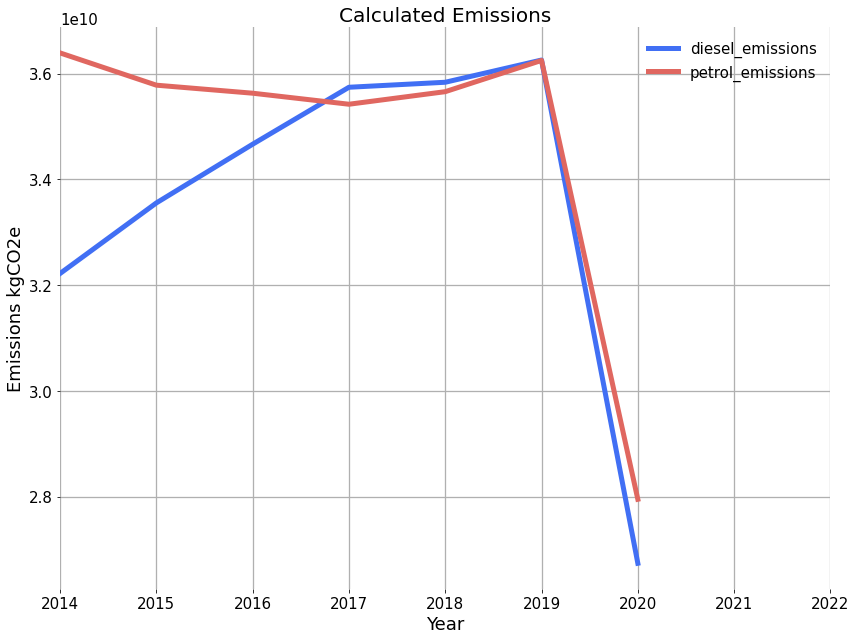

In [37]:
fig, ax = plt.subplots()

df[[
    'diesel_emissions', 
    'petrol_emissions', 
#     'diesel_emissions_2021', 
#     'petrol_emissions_2021'
]].plot(ax=ax)

ax.set_title('Calculated Emissions')
ax.set_ylabel('Emissions kgCO2e')
ax.set_xlabel('Year')

# plt.savefig('plots/')
plt.show()

### 2.4 Comparison with Official NAEI Emissions

In [38]:
df['total_kgCO2e_calc'] = df.apply(lambda row: row['diesel_emissions'] + row['petrol_emissions'], axis=1)
# df['total_kgCO2e_calc_2021'] = df.apply(lambda row: row['diesel_emissions_2021'] + row['petrol_emissions_2021'], axis=1)

In [39]:
df = df.merge(emt.resample('YS').last()[['1A3bi_Cars']]*1000000, how='left', left_index=True, right_index=True)

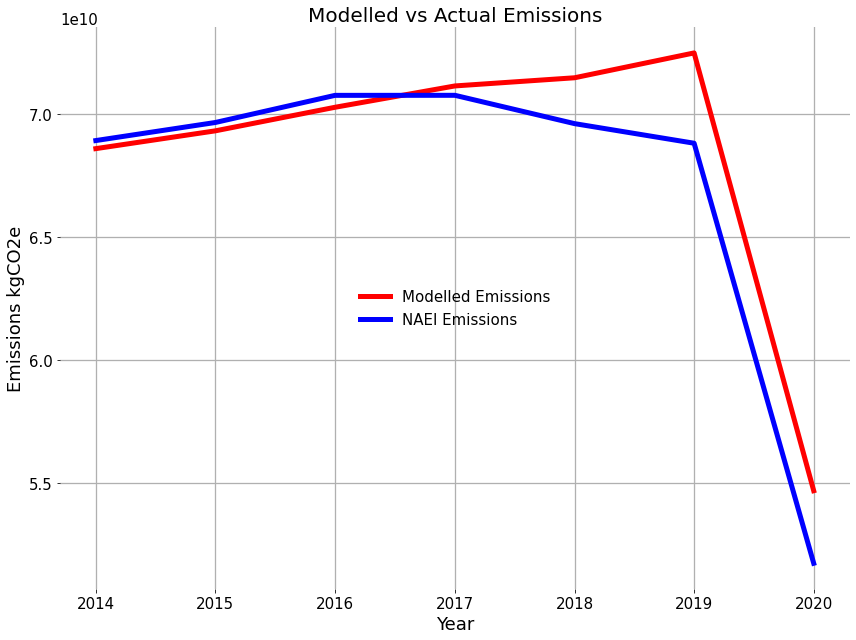

In [40]:
fig, ax = plt.subplots()
ax.plot(df.resample('YS').first().total_kgCO2e_calc, c='r', label='Modelled Emissions')
# ax.plot(df.resample('YS').first().total_kgCO2e_calc_2021, c='g', label='Modelled Emissions_2021')
ax.plot(df.resample('YS').first()['1A3bi_Cars'], c='b', label='NAEI Emissions')
# NB: resample above is just so that on the plot it displays emissions in that year directly above that year. So just for display purposes. 

ax.legend()

ax.set_ylabel('Emissions kgCO2e')
ax.set_xlabel('Year')
ax.set_title('Modelled vs Actual Emissions')
# plt.savefig('plots/accuracy_calc.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')
plt.show()

In [41]:
df['error'] = df['total_kgCO2e_calc'] / df['1A3bi_Cars']

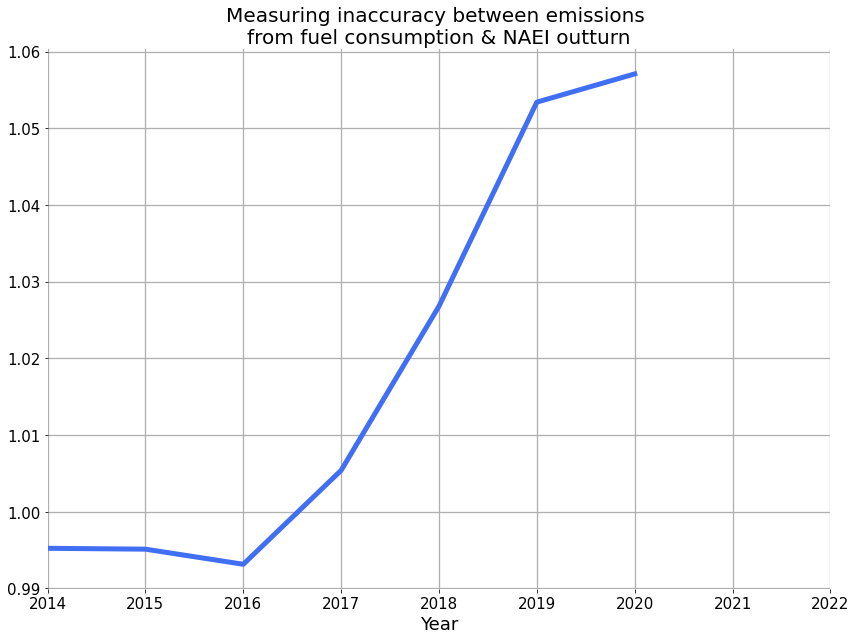

In [42]:
fig, ax = plt.subplots()

df.error.plot(ax=ax)
ax.set_title('Measuring inaccuracy between emissions \nfrom fuel consumption & NAEI outturn')
ax.set_xlabel('Year')
# plt.savefig('plots/accuracy_ratio.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')
plt.show()

It looks like we are usually within a 5 percentage point margin of error. That's probably tolerable. 

## Part 3: Scenario-ing

In this section, I am going to create some new scenarios and forecast what it might look like. 

Our forecast will be built into dataframe `dfp`

### 3.1 Scenario A: Car market growing according to trend, growth in line with ZEV mandate. 




In [43]:
# How many ICE sales should we allocate to diesel registrations? This just takes the last year's diesel share of ICE sales, i.e. 11%
diesel_share_of_ice = ecc[['Diesel', 'Petrol']].div(ecc[['Diesel', 'Petrol']].sum(axis=1), axis=0).iloc[-1].Diesel
diesel_share_of_ice -= 0.1

In [44]:
diesel_share_of_ice

0.06264730508580205

In [45]:
# Vehicle retirements
ret = ecc.copy()
# Retirements happen automatically after X years
car_lifespan = 18
ret.index = ecc.index+pd.DateOffset(years=car_lifespan)
ret = ret.fillna(0)
# ret.to_csv('data/retirements.csv')

In [46]:
start = '2023-01-01'
end = '2050-01-01'

new_index = pd.date_range(start=start, end=end, freq='YS')
dfp = pd.DataFrame(index=new_index)
years = dfp.index

# Overal market size
total_annual_retirements = ret[ret.index > start].sum(axis=1).values
total_annual_sales = []
sales = ecc.sum(axis=1).iloc[-5:].mean()
sales = 1500000
# sales = ecc.sum(axis=1).mean()

# By chosing all but the last 3 years, we're taking pre-pandemic growth
growth = 1 #+ ecc.sum(axis=1).iloc[12:-5].pct_change().mean()

for i, year in enumerate(years):
    # try:
    #     total_annual_sales.append(total_annual_retirements[i])
    # except:
        # sales *= growth
        # total_annual_sales.append(sales)
        
    sales *= growth
    total_annual_sales.append(sales)

zev_trajectory = []

# i.e. ZEVs continue to constitute 8% of registrations from here on
# zev_mandate = [.08 for x in years]

# `zev_mandate` is the trajectory set out by DfT except for the first year (2023) which has no percentage target. 
zev_mandate = [.17, .22, .28, .33, .38, .52, .66, .80, .84, .88, .92, .96, 1]
for i, e in enumerate(years):
    try:
        zev_trajectory.append(zev_mandate[i])
    except:
        zev_trajectory.append(1)

new_electric = []
for i, e in enumerate(years):
    new_electric.append(zev_trajectory[i] * total_annual_sales[i])

# # Hybrid trajectory
# # hybrid_traj = [.25, .26, .27, .28, .29, .30, .66, .80, .84, .88, .92, .96, 1]
# new_hybrid = []
# for i, e in enumerate(years):
#     new_hybrid

total_ice_sales = []
for i, e in enumerate(years):
    total_ice_sales.append(total_annual_sales[i] - new_electric[i])


new_diesel = []
for i, e in enumerate(years):
    new_diesel.append(total_ice_sales[i] * diesel_share_of_ice)

new_petrol = []
for i, e in enumerate(years):
    new_petrol.append(total_ice_sales[i] - new_diesel[i])

dfp['new_diesel'] = new_diesel
dfp['new_petrol'] = new_petrol
dfp['new_electric'] = new_electric

In [47]:
diesel_parc = []
petrol_parc = []
electric_parc = []

# Our starting values, which will be changed by the new registration statistics. 
diesel = cars.Diesel.iloc[-1]
petrol = cars.Petrol.iloc[-1]
electric = cars['Pure Electric'].iloc[-1]

# _rets means a list of the number of cars that get retired each year, from that fueltype. 
# This is a bit complex. We take the number of retired cars as being the number registered X many years ago, where X is our estimate as to how long a typical car will live. 
# We take historic car registration statistics to calculate this. But there is an issue if we say that cars are going to live for 30 years, i.e. longer than our dataframe of new registrations. 
# We solve that issue by adding in Y number of years where 0 retirements happen, where Y is set at the number of years between the registrations. 
diesel_rets = [0 for x in list(range(round((ret.index.min() - pd.to_datetime(start)).days/365)))] + ret[ret.index >= start].Diesel.tolist() + new_diesel
petrol_rets = [0 for x in list(range(round((ret.index.min() - pd.to_datetime(start)).days/365)))] + ret[ret.index >= start].Petrol.tolist() + new_petrol
electric_rets = [0 for x in list(range(round((ret.index.min() - pd.to_datetime(start)).days/365)))] + ret[ret.index >= start]['Pure Electric'].tolist() + new_electric

# Adjust the retirement rates for previously registered diesels
# What is happening here is we are taking the sum of (the vehicles already in the parc, and the vehicles that we're projecting will be added to the parc),
# then we are finding the difference between all the vehicles the model will remove from the parc. 
# i.e. We are fixing the problem of the model adding/removing too many vehicles
# That difference needs to be accounted for. That is done so very simplistically (and controversially). If there is a 10% difference, then the retirements are all uplifted by 10%. 
left_over_diesels = (cars.Diesel.iloc[-1] + sum(new_diesel)) - sum(ret[ret.index >= start].Diesel.tolist() + new_diesel)
diesel_retirement_factor = (left_over_diesels + sum(ret[ret.index >= start].Diesel.tolist() + new_diesel)) / sum(ret[ret.index >= start].Diesel.tolist() + new_diesel)
diesel_rets = [diesel_retirement_factor*x for x in diesel_rets]

left_over_petrols = (cars.Petrol.iloc[-1] + sum(new_petrol)) - sum(ret[ret.index >= start].Petrol.tolist() + new_petrol)
petrol_retirement_factor = (left_over_petrols + sum(ret[ret.index >= start].Petrol.tolist() + new_petrol)) / sum(ret[ret.index >= start].Petrol.tolist() + new_petrol)
petrol_rets = [petrol_retirement_factor*x for x in petrol_rets]

# We need to adjust the number of diesel and petrol vehicles 
for i, e in enumerate(years):
    diesel = round(diesel - (diesel_rets[i]-new_diesel[i]))
    petrol = round(petrol - (petrol_rets[i]-new_petrol[i]))
    electric = round(electric - (electric_rets[i]-new_electric[i]))
    
#     This is a little safeguard to prevent the parc ever from going negative, which it shouldn't, except as a result of a rounding error
    if diesel >= 0:
        diesel_parc.append(diesel)
    else:
        diesel_parc.append(0)
    
    if petrol >= 0:
        petrol_parc.append(petrol)
    else:
        petrol_parc.append(0)
    
    if electric >= 0:
        electric_parc.append(electric)
    else:
        electric_parc.append(0)

In [48]:
# Assumptions about mileage

# Simple static mileage taking the average
diesel_mileage = df.diesel_mileage.iloc[-12:-3].mean()
petrol_mileage = df.petrol_mileage.iloc[-12:-3].mean()
electric_mileage = df.electric_mileage.iloc[-12:-3].mean() 

In [49]:
# Assumptions about MPG

diesel_mpg = df.iloc[:-3].diesel_economy.mean()
petrol_mpg = df.iloc[:-3].petrol_economy.mean()
petrol_mpg_start = df.iloc[:-3].petrol_economy.mean()

# More sophisticated assumptions about MPG
petrol_mpg = []
total_new_petrols = 0


for i, e in enumerate(years):
    total_new_petrols += new_petrol[i]
    old_petrols = petrol_parc[i] - total_new_petrols
    if old_petrols < 0:
        old_petrols = 0
    old_petrols_mpgs_cars = old_petrols * petrol_mpg_start
    new_petrols_mpgs_cars = total_new_petrols * 50
    total_mpg = old_petrols_mpgs_cars + new_petrols_mpgs_cars
    parc_mpg = total_mpg / petrol_parc[i]
    if parc_mpg > 50:
        parc_mpg = 50
    petrol_mpg.append(parc_mpg)
    print(parc_mpg)

36.34690094256507
37.2277501523017
38.07117694458355
38.85597665882544
39.602145059215566
40.234003810472096
40.7429754324146
41.18402546987634
41.67288960321749
42.21701444201789
42.85219880112878
43.58547166800285
44.45762315659105
45.646246675866365
47.2572880818076
48.61633332238698
50
50
50
50
50
50
50
50
50
50
50
50


In [50]:
dfp.shape

(28, 3)

In [51]:
len(petrol_mpg)

28

In [52]:
dfp['diesel'] = diesel_parc
dfp['petrol'] = petrol_parc
dfp['electric'] = electric_parc

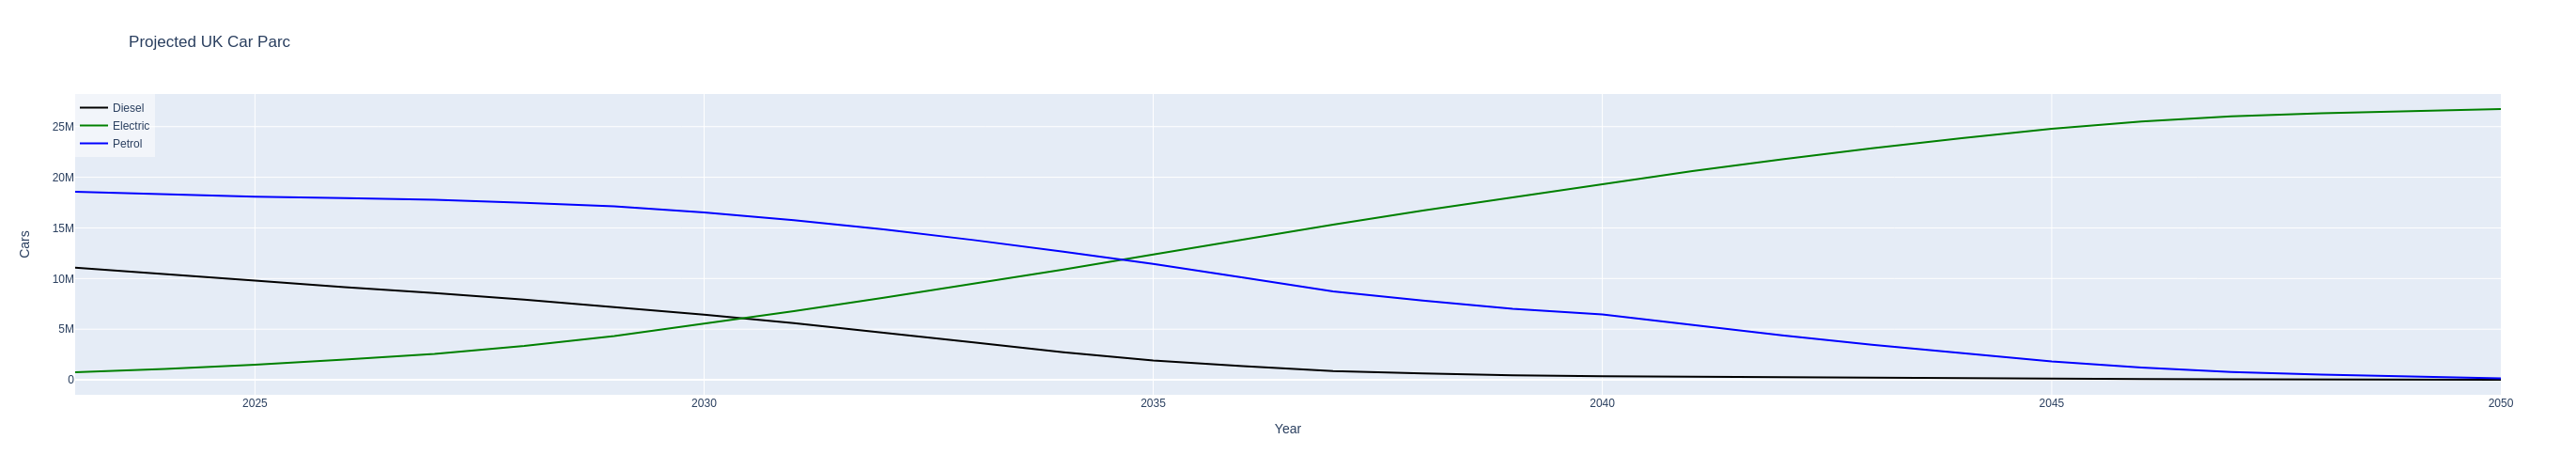

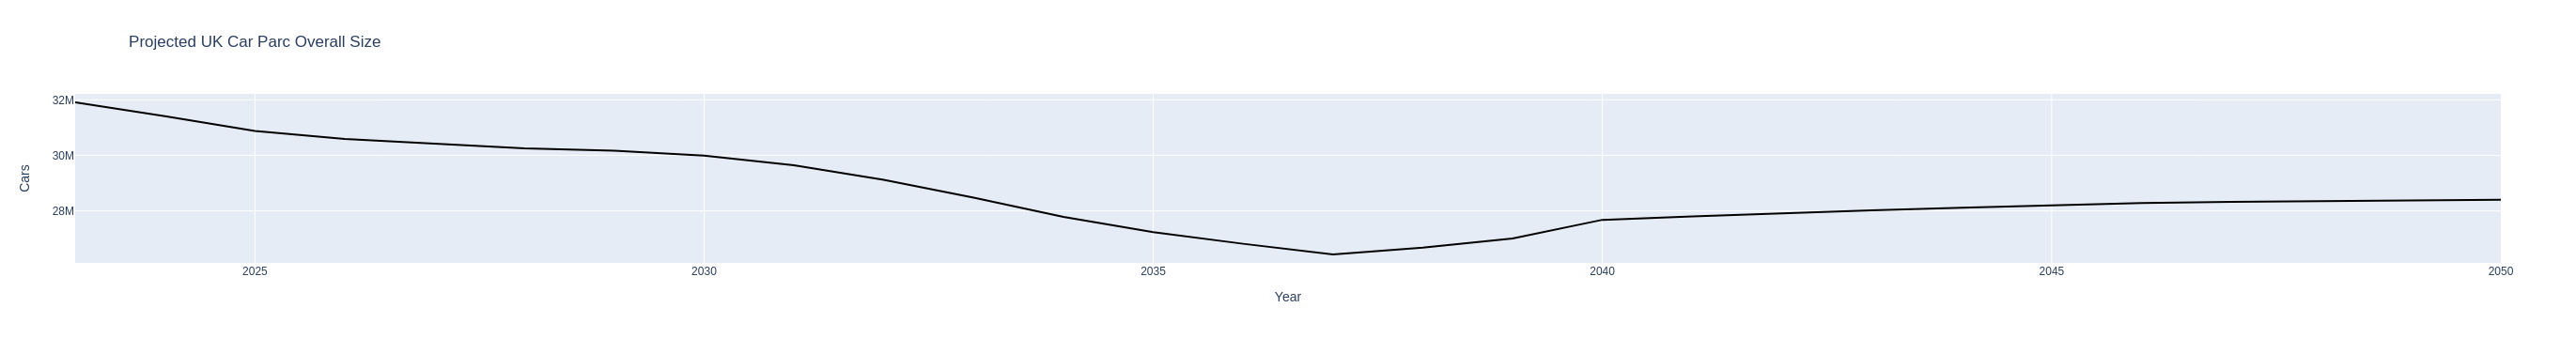

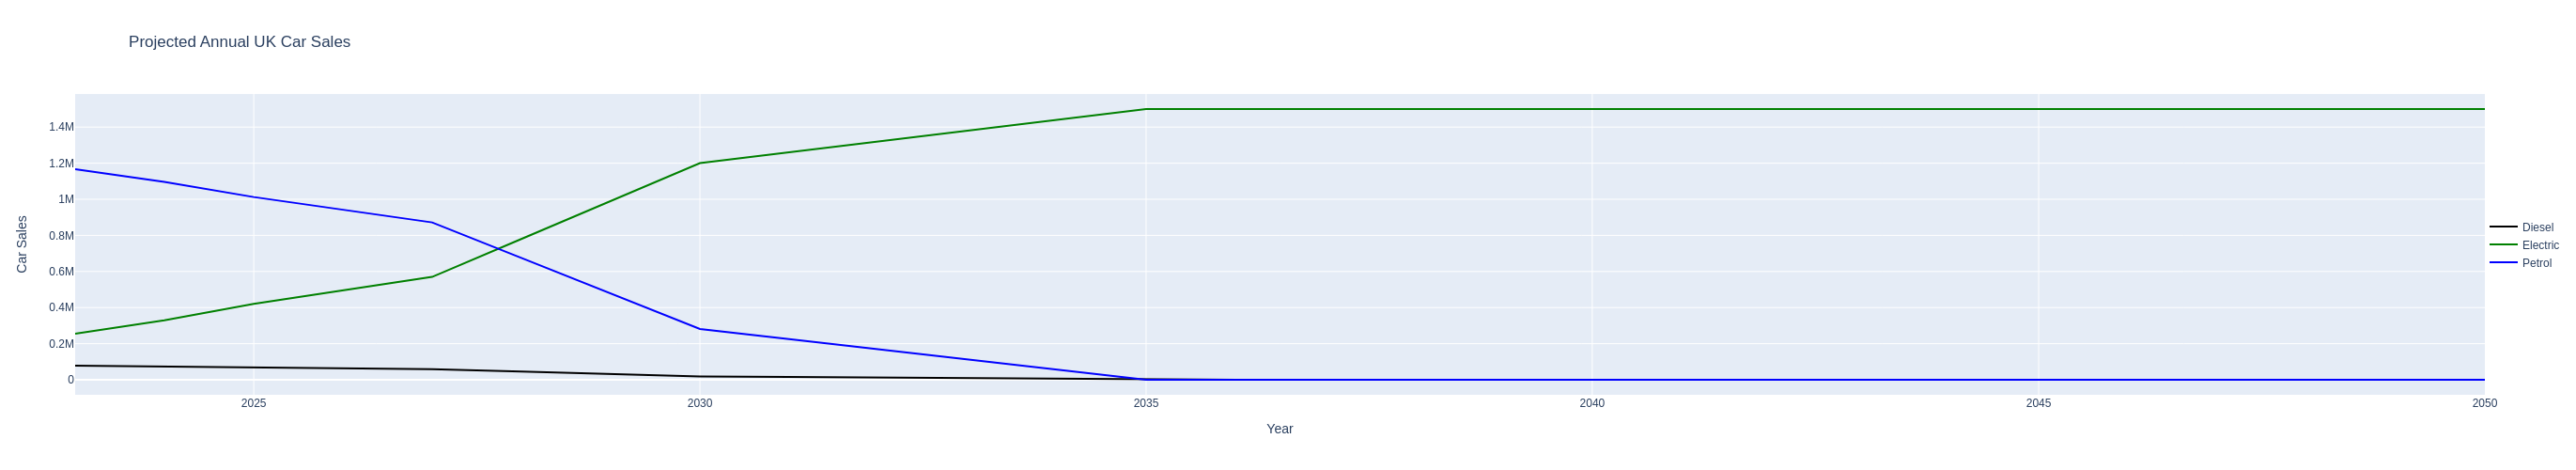

In [53]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=dfp.index, y=dfp.diesel, mode='lines', name='Diesel', line=dict(color='black')))
fig.add_trace(go.Scatter(x=dfp.index, y=dfp.electric, mode='lines', name='Electric', line=dict(color='green')))
fig.add_trace(go.Scatter(x=dfp.index, y=dfp.petrol, mode='lines', name='Petrol', line=dict(color='blue')))

fig.update_layout(
    title='Projected UK Car Parc',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Cars'),
    legend=dict(x=0, y=1, bgcolor='rgba(255, 255, 255, 0.5)'),
    autosize=False,
    width=800,
    height=500,
    margin=dict(t=100)
)

fig2 = go.Figure()

fig2.add_trace(go.Scatter(x=dfp.index, y=dfp.sum(axis=1), mode='lines', line=dict(color='black')))

fig2.update_layout(
    title='Projected UK Car Parc Overall Size',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Cars'),
    autosize=False,
    width=800,
    height=300,
    margin=dict(t=100)
)

fig3 = go.Figure()

fig3.add_trace(go.Scatter(x=dfp.index, y=dfp.new_diesel, mode='lines', name='Diesel', line=dict(color='black')))
fig3.add_trace(go.Scatter(x=dfp.index, y=dfp.new_electric, mode='lines', name='Electric', line=dict(color='green')))
fig3.add_trace(go.Scatter(x=dfp.index, y=dfp.new_petrol, mode='lines', name='Petrol', line=dict(color='blue')))

fig3.update_layout(
    title='Projected Annual UK Car Sales',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Car Sales'),
    legend=dict(x=1, y=0.5, bgcolor='rgba(255, 255, 255, 0.5)'),
    autosize=False,
    width=800,
    height=500,
    margin=dict(t=100)
)

fig.write_image('plots/parc_projection.png', format='png', width=800, height=500, scale=2)
fig2.write_image('plots/parc_size_projection.png', format='png', width=800, height=500, scale=2)
fig3.write_image('plots/car_sales_projection.png', format='png', width=800, height=500, scale=2)
fig.show()

fig2.show()

fig3.show()

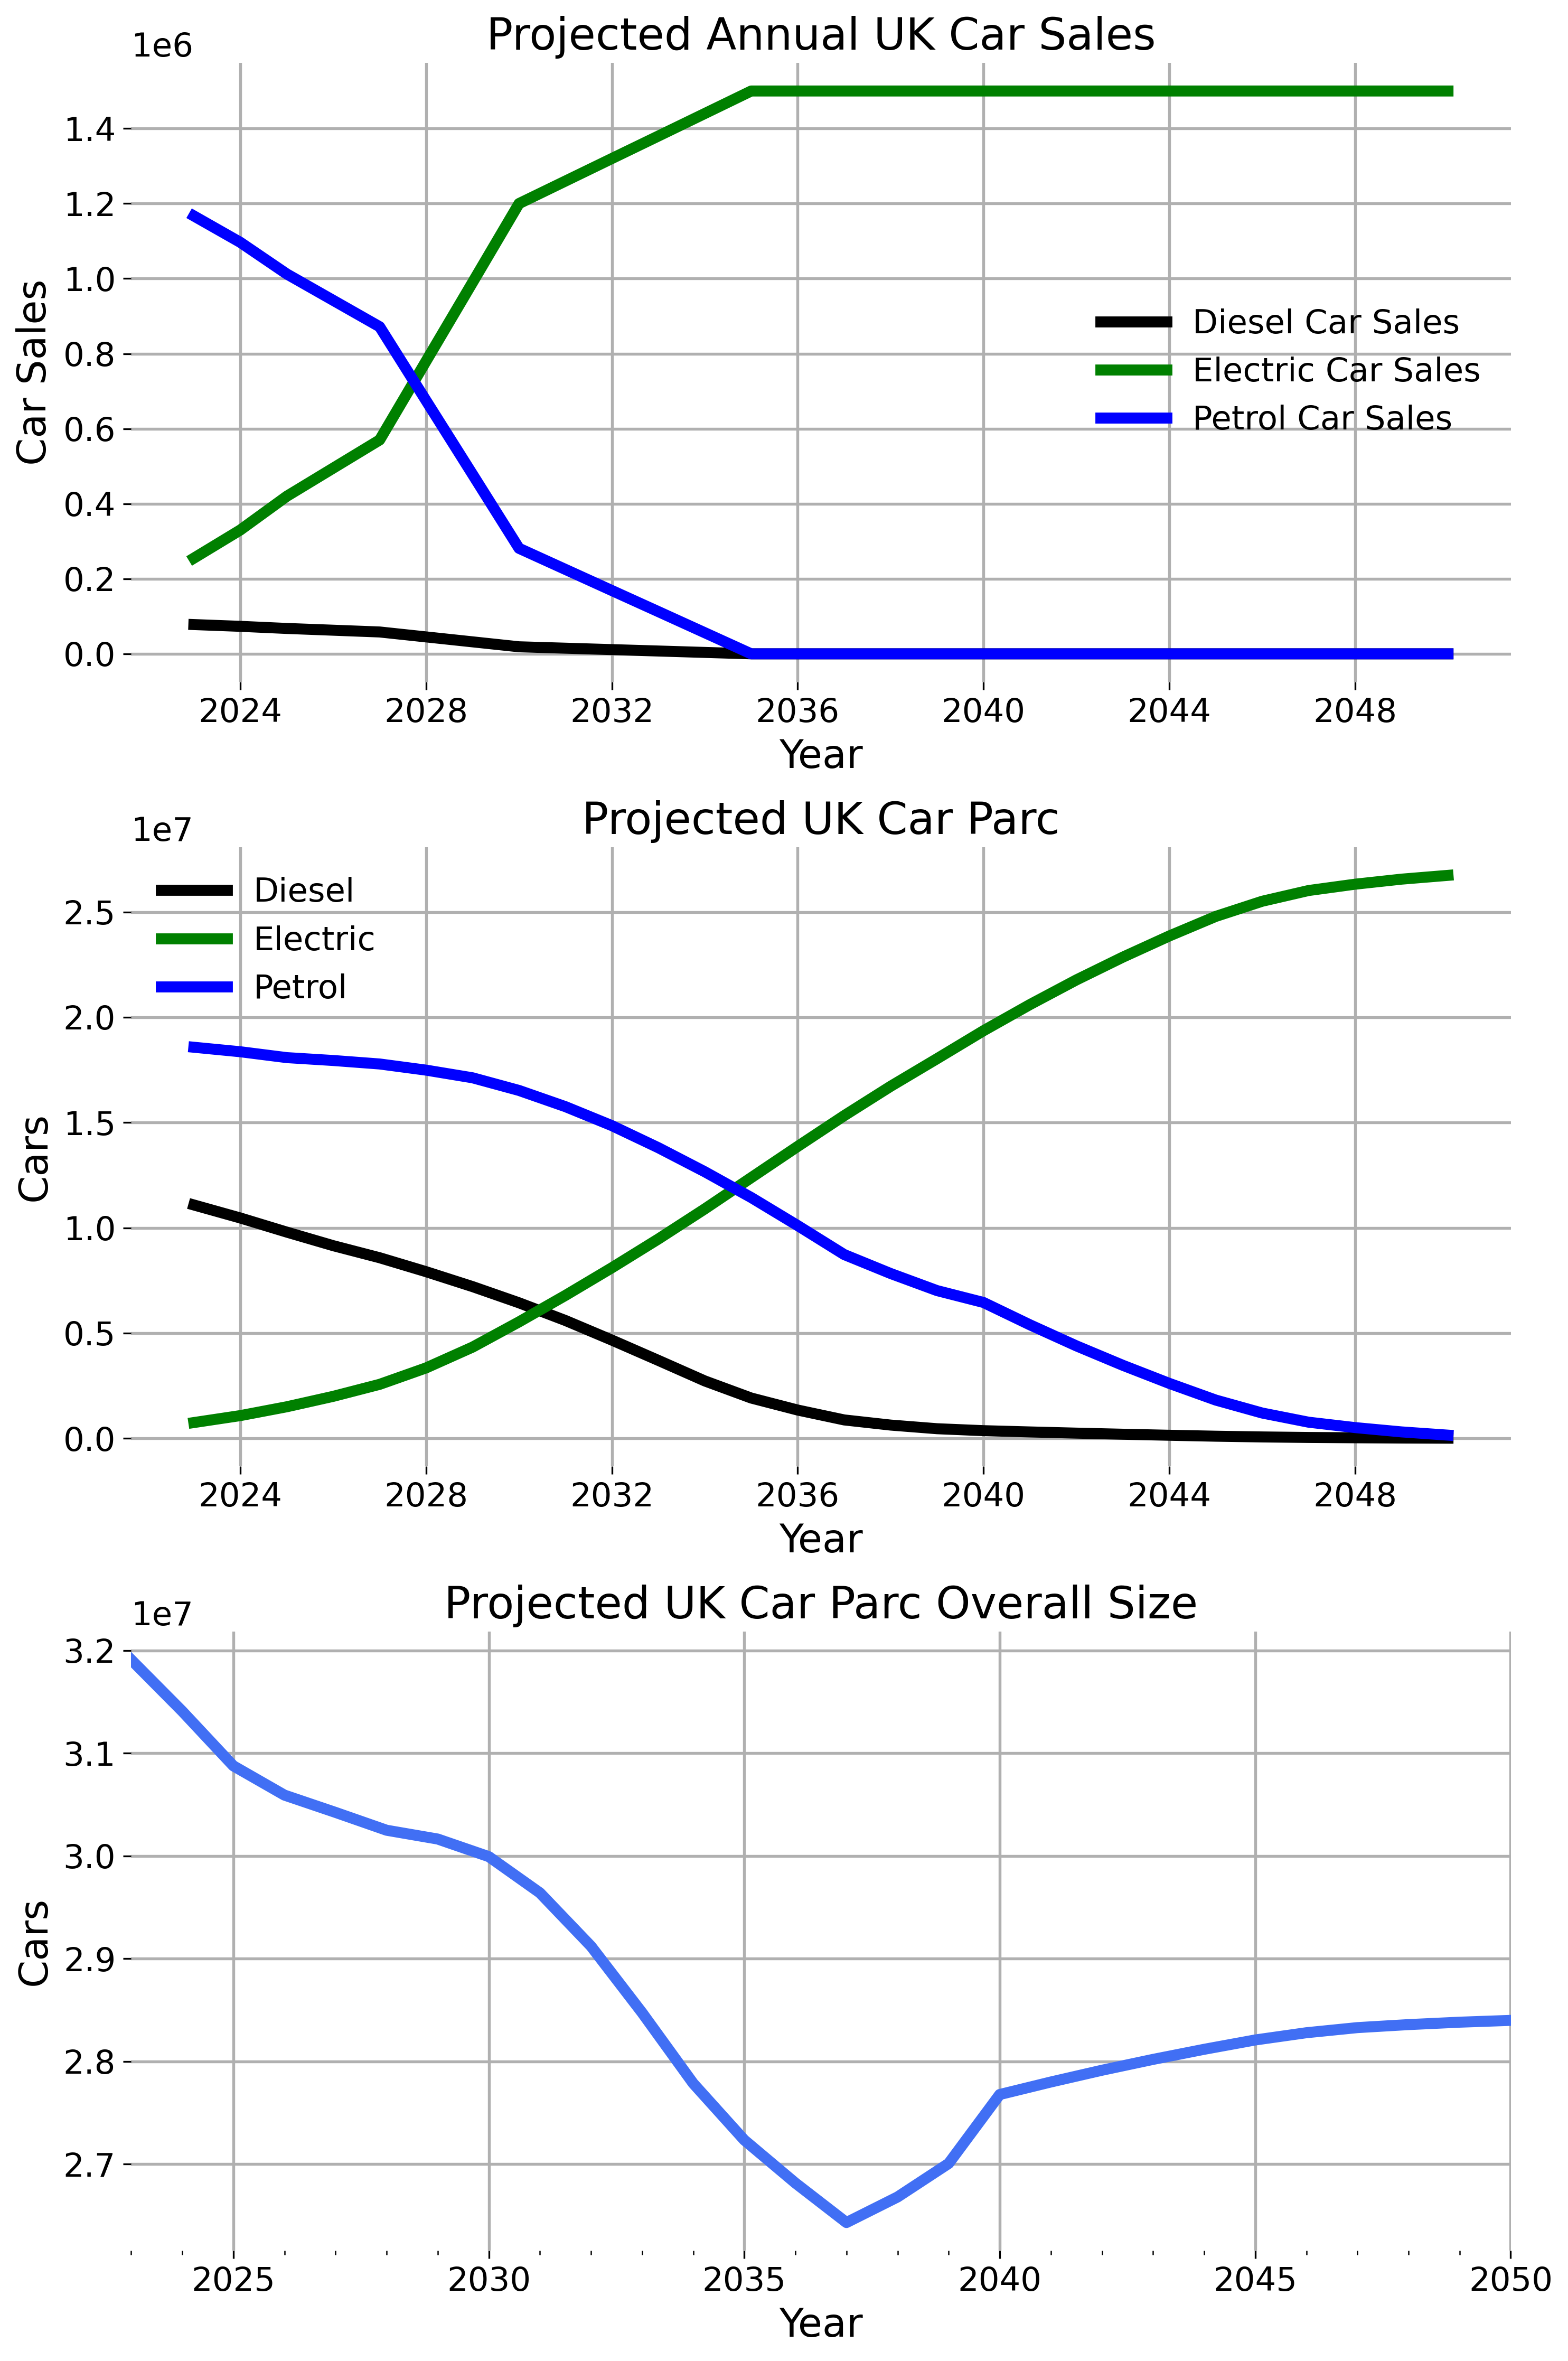

In [54]:
fig, [ax3, ax, ax2] = plt.subplots(3, 1, figsize=(10, 15), dpi=300)

# dfp[['diesel', 'electric', 'petrol']].plot(ax=ax, colors=['black', '#183363', 'green'])

ax.plot(dfp.diesel, label='Diesel', color='black')
ax.plot(dfp.electric, label='Electric', color='green')
ax.plot(dfp.petrol, label='Petrol', color='blue')

ax.set_title('Projected UK Car Parc')
ax.set_ylabel('Cars')
ax.set_xlabel('Year')

ax.legend(['Diesel', 'Electric', 'Petrol'], loc='upper left')

dfp.sum(axis=1).plot(ax=ax2)

ax2.set_title('Projected UK Car Parc Overall Size')
ax2.set_ylabel('Cars')
ax2.set_xlabel('Year')

# dfp[['new_diesel', 'new_electric', 'new_petrol']].plot(ax=ax3)
ax3.plot(dfp.new_diesel, label='Diesel', color='black')
ax3.plot(dfp.new_electric, label='Electric', color='green')
ax3.plot(dfp.new_petrol, label='Petrol', color='blue')

ax3.set_title('Projected Annual UK Car Sales')
ax3.set_ylabel('Car Sales')
ax3.set_xlabel('Year')

ax3.legend(['Diesel Car Sales', 'Electric Car Sales', 'Petrol Car Sales'], loc='center right')


plt.savefig('plots/projection.png', transparent=False, bbox_inches='tight', dpi=300)

plt.show()

In [55]:
# SAME AS ABOVE BUT WITH PERCENTAGE FIGURES FOR PARC

# fig, [ax3, ax, ax2] = plt.subplots(3, 1, figsize=(10, 15), dpi=300)

# dfp[['diesel', 'electric', 'petrol']].div(dfp[['diesel', 'electric', 'petrol']].sum(axis=1), axis=0).plot(ax=ax)

# ax.set_title('Projected UK Car Parc')
# ax.set_ylabel('Cars')
# ax.set_xlabel('Year')

# dfp.sum(axis=1).plot(ax=ax2)

# ax2.set_title('Projected UK Car Parc Overall Size')
# ax2.set_ylabel('Cars')
# ax2.set_xlabel('Year')

# dfp[['new_diesel', 'new_electric', 'new_petrol']].plot(ax=ax3)

# ax3.set_title('Projected UK Vehicle Sales')
# ax3.set_ylabel('Cars')
# ax3.set_xlabel('Year')

# plt.savefig('plots/projection.png', transparent=False, bbox_inches='tight', dpi=300)

# plt.show()

Now we enter our mileage assumptions. 

In [56]:
dfp['diesel_miles'] = diesel_mileage #* .85
dfp['petrol_miles'] = petrol_mileage #* .85
dfp['electric_miles'] = electric_mileage #* .9

Now calculate vmt for each fueltype as product of annual mileage and parc. 

In [57]:
dfp['diesel_vmt'] = dfp.apply(lambda row: row.diesel_miles * row.diesel, axis=1)
dfp['petrol_vmt'] = dfp.apply(lambda row: row.petrol_miles * row.petrol, axis=1)
dfp['electric_vmt'] = dfp.apply(lambda row: row.electric_miles * row.electric, axis=1)

Now we enter in our MPG assumptions

In [58]:
dfp['diesel_economy'] = diesel_mpg
dfp['petrol_economy'] = petrol_mpg

Now calculate total gallons of petrol and diesel consumed.

In [59]:
dfp['car_petrol_consumption_gallons'] = dfp.apply(lambda row: row.petrol_vmt / row.petrol_economy, axis=1)
dfp['car_diesel_consumption_gallons'] = dfp.apply(lambda row: row.diesel_vmt/ row.diesel_economy, axis=1)

In [60]:
dfp['petrol_consumption'] = dfp.car_petrol_consumption_gallons.apply(lambda x: ((x/219.969)*.98)/1000)
dfp['diesel_consumption'] = dfp.car_diesel_consumption_gallons.apply(lambda x: ((x/219.969)*.86)/1000)

Now calculate emissions from each kind of fuel. 

In [61]:
dfp['diesel_emissions'] = dfp.diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.23686)
dfp['petrol_emissions'] = dfp.petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22980)

In [62]:
df.iloc[-2:, 8:]

petrol_mileage  electric_mileage    diesel_vmt    petrol_vmt  \
variable                                                                   
2021-01-01     5072.091349       8039.995988  8.563183e+10  9.496577e+10   
2022-01-01     5705.614549       9033.500161  9.597255e+10  1.073466e+11   

            electric_vmt    hybrid_vmt  car_diesel_consumption  \
variable                                                         
2021-01-01  3.087978e+09  2.595570e+09                     NaN   
2022-01-01  4.481357e+09  3.358613e+09                     NaN   

            car_petrol_consumption  pure_petrol_share  hybrid_petrol_share  \
variable                                                                     
2021-01-01                     NaN           0.981227             0.018773   
2022-01-01                     NaN           0.978568             0.021432   

            ...  hybrid_car_petrol_consumption_gallons  pure_petrol_economy  \
variable    ...                                                               
2021-01-01  ...                                    NaN                  NaN   
2022-01-01  ...                                    NaN                  NaN   

            diesel_economy  hybrid_economy  petrol_economy  diesel_emissions  \
variable                                                                       
2021-01-01             NaN             NaN             NaN               NaN   
2022-01-01             NaN             NaN             NaN               NaN   

            petrol_emissions  total_kgCO2e_calc  1A3bi_Cars  error  
variable                                                            
2021-01-01               NaN                NaN         NaN    NaN  
2022-01-01               NaN                NaN         NaN    NaN  

[2 rows x 25 columns]

In [63]:
# Let's fill in the gaps with an estimate for 2021 and 2022

df_sel = df.iloc[-2:]

df_sel['diesel_economy'] = diesel_mpg
df_sel['petrol_economy'] = petrol_mpg_start

df_sel['car_petrol_consumption_gallons'] = df_sel.apply(lambda row: row.petrol_vmt / row.petrol_economy, axis=1)
df_sel['car_diesel_consumption_gallons'] = df_sel.apply(lambda row: row.diesel_vmt/ row.diesel_economy, axis=1)

df_sel['petrol_consumption'] = df_sel.car_petrol_consumption_gallons.apply(lambda x: ((x/219.969)*.98)/1000)
df_sel['diesel_consumption'] = df_sel.car_diesel_consumption_gallons.apply(lambda x: ((x/219.969)*.86)/1000)

df_sel['diesel_emissions'] = df_sel.diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.23686)
df_sel['petrol_emissions'] = df_sel.petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22980)

<ipython-input-63-2745f4e33444>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-2745f4e33444>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-2745f4e33444>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-63-2745f4e

In [64]:
historical = pd.concat([df.iloc[:-2], df_sel])
forecast = dfp.copy()
# forecast = forecast.resample('YS').first()

In [65]:
historical

Diesel    Hybrid      Other      Petrol  Pure Electric  \
variable                                                                 
2014-01-01  10968863.0    7232.0   246560.0  18739719.0        14328.0   
2015-01-01  11651974.0   22988.0   308603.0  18574731.0        24451.0   
2016-01-01  12296229.0   47909.0   386247.0  18492246.0        34488.0   
2017-01-01  12615832.0   76282.0   490230.0  18423529.0        48907.0   
2018-01-01  12662139.0  112966.0   619006.0  18568990.0        64881.0   
2019-01-01  12567953.0  140534.0   778526.0  18894394.0        99473.0   
2020-01-01  12255205.0  195529.0  1084319.0  18792569.0       201678.0   
2021-01-01  11884303.0  296492.0  1630489.0  18723197.0       384077.0   
2022-01-01  11698381.0  344658.0  1969425.0  18814210.0       496082.0   

            diesel_mileage  hybrid_mileage  other_ft_mileage  petrol_mileage  \
variable                                                                       
2014-01-01    10936.202744    10562.156377      10736.490969     6830.794536   
2015-01-01    10644.794975    10716.697489      10484.035654     6725.032887   
2016-01-01    10376.604466    10857.634603      10127.260827     6624.450468   
2017-01-01    10112.599653    10998.586613       9936.503505     6531.131889   
2018-01-01     9781.636033    10790.694828       9935.565102     6390.194843   
2019-01-01     9498.001392    10561.817871      10344.429713     6303.511363   
2020-01-01     8273.260261     9350.317254       9315.795845     5675.050270   
2021-01-01     7205.456602     8754.267393       8157.842332     5072.091349   
2022-01-01     8203.917407     9744.769186       9691.168302     5705.614549   

            electric_mileage  ...  diesel_economy  hybrid_economy  \
variable                      ...                                   
2014-01-01       6132.168427  ...       46.520861       51.930747   
2015-01-01       6928.237950  ...       46.187605       51.590474   
2016-01-01       7308.252598  ...       45.991118       50.889594   
2017-01-01       7795.994137  ...       44.599864       50.376339   
2018-01-01       8108.767237  ...       43.184275       49.460786   
2019-01-01       8139.812848  ...       41.137484       48.909527   
2020-01-01       7840.222633  ...       47.381756       56.989381   
2021-01-01       8039.995988  ...       44.603535             NaN   
2022-01-01       9033.500161  ...       44.603535             NaN   

            petrol_economy  diesel_emissions  petrol_emissions  \
variable                                                         
2014-01-01       36.358027      3.221900e+10      3.639142e+10   
2015-01-01       36.134669      3.355389e+10      3.578116e+10   
2016-01-01       35.667961      3.466449e+10      3.562931e+10   
2017-01-01       35.336843      3.574183e+10      3.542070e+10   
2018-01-01       34.728491      3.583641e+10      3.565834e+10   
2019-01-01       34.363564      3.625690e+10      3.624951e+10   
2020-01-01       40.095295      2.673731e+10      2.794797e+10   
2021-01-01       35.431593      2.067637e+10      3.191323e+10   
2022-01-01       35.431593      2.317321e+10      3.607381e+10   

            total_kgCO2e_calc    1A3bi_Cars     error  petrol_consumption  \
variable                                                                    
2014-01-01       6.861041e+10  6.893919e+10  0.995231                 NaN   
2015-01-01       6.933506e+10  6.967519e+10  0.995118                 NaN   
2016-01-01       7.029380e+10  7.077882e+10  0.993147                 NaN   
2017-01-01       7.116252e+10  7.078080e+10  1.005393                 NaN   
2018-01-01       7.149475e+10  6.962848e+10  1.026803                 NaN   
2019-01-01       7.250641e+10  6.883038e+10  1.053407                 NaN   
2020-01-01       5.468528e+10  5.173207e+10  1.057087                 NaN   
2021-01-01                NaN           NaN       NaN        11941.008160   
2022-01-01                NaN           NaN       NaN        13

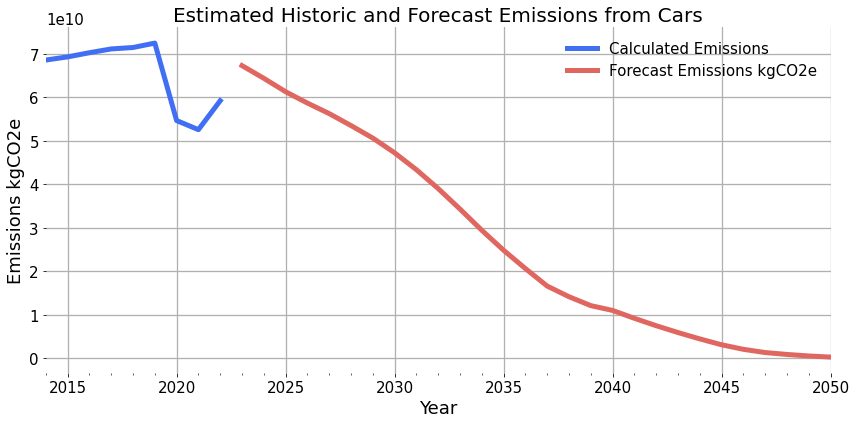

In [66]:
fig, ax=plt.subplots(figsize=(12, 6))

pd.concat([df[['diesel_emissions', 'petrol_emissions']].dropna(),
df_sel[['diesel_emissions', 'petrol_emissions']]]).sum(axis=1).plot(ax=ax, label='Calculated Emissions')
dfp[['diesel_emissions', 'petrol_emissions']].sum(axis=1).plot(ax=ax, label='Forecast Emissions kgCO2e')

ax.legend(loc='upper right')
ax.set_ylabel('Emissions kgCO2e')
ax.set_xlabel('Year')
ax.set_title('Estimated Historic and Forecast Emissions from Cars')
# ax.set_ylim(0, 4300000000)

# plt.savefig('plots/emissions.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')
plt.savefig('plots/car_emissions.png', transparent=False, bbox_inches='tight', dpi=300)


plt.show()

<AxesSubplot:>

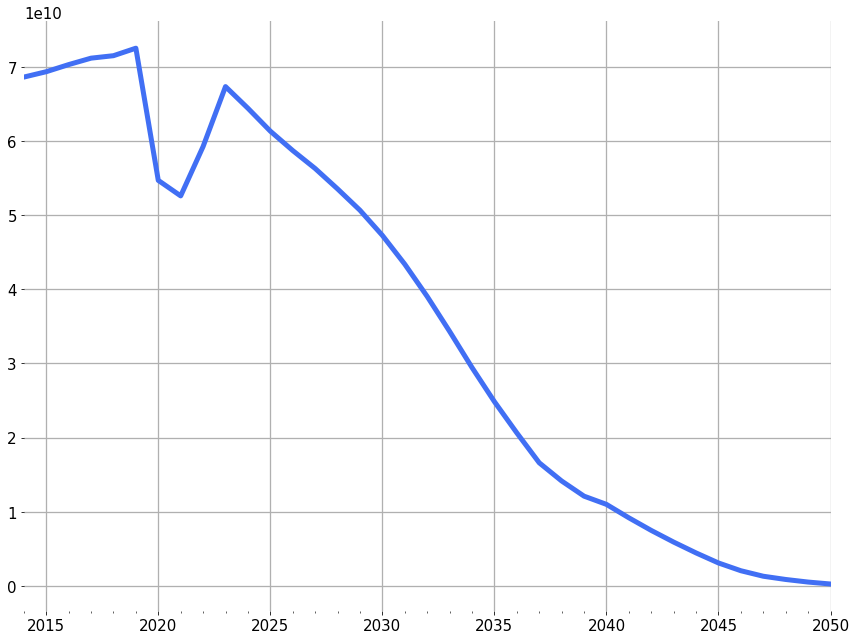

In [67]:
pd.concat([df[['diesel_emissions', 'petrol_emissions']].dropna(),
df_sel[['diesel_emissions', 'petrol_emissions']],
dfp[['diesel_emissions', 'petrol_emissions']]]).sum(axis=1).plot()

In [68]:
forecast.columns

Index(['new_diesel', 'new_petrol', 'new_electric', 'diesel', 'petrol',
       'electric', 'diesel_miles', 'petrol_miles', 'electric_miles',
       'diesel_vmt', 'petrol_vmt', 'electric_vmt', 'diesel_economy',
       'petrol_economy', 'car_petrol_consumption_gallons',
       'car_diesel_consumption_gallons', 'petrol_consumption',
       'diesel_consumption', 'diesel_emissions', 'petrol_emissions'],
      dtype='object')

Text(0.5, 1.0, 'Forecast and Actual UK Cars on the Road')

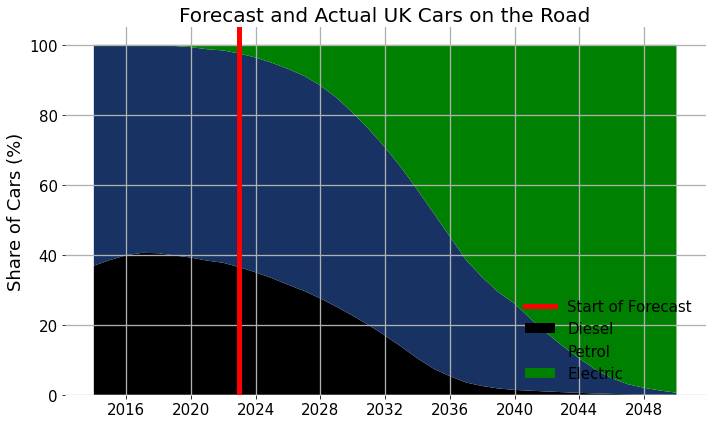

In [69]:
cdf_sel = pd.concat([
    historical[['Diesel', 'Petrol', 'Pure Electric']],
    forecast[['diesel', 'petrol', 'electric']].rename(columns={'diesel': 'Diesel', 'petrol': 'Petrol', 'electric': 'Pure Electric'})
])

cdf_sel_perc = 100*cdf_sel.div(cdf_sel.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.stackplot(cdf_sel_perc.index, cdf_sel_perc.Diesel,  cdf_sel_perc.Petrol, cdf_sel_perc['Pure Electric'], colors=['black', '#183363', 'green'], labels=['Diesel', 'Petrol', 'Electric'])

ax.axvline(pd.Timestamp('2022-12-31'), color='red', label='Start of Forecast')
ax.legend(loc='lower right', facecolor='white', edgecolor='white')

# ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_ylabel('Share of Cars (%)')

ax.set_title('Forecast and Actual UK Cars on the Road')



# ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')

In [70]:
import dateutil.relativedelta

In [71]:
cdf_sel = pd.concat([
    historical[['Diesel', 'Petrol', 'Pure Electric']].rename(columns={
        'Diesel': 'Diesel Observed',
        'Petrol': 'Petrol Observed',
        'Pure Electric': 'Electric'
    }
    ),
    forecast[['diesel', 'petrol', 'electric']].rename(columns={
        'diesel': 'Diesel', 
        'petrol': 'Petrol', 
        'electric': 'Pure Electric'
    })
])


In [72]:
# Prepare Parc Forecast
cdf_sel.reset_index(inplace=True)
cdf_sel['dateOfForecast'] = pd.to_datetime((dt.today() - dateutil.relativedelta.relativedelta(months=1)).strftime('%Y-%m-01'))
# cdf_sel.reset_index(inplace=True)
cdf_sel.rename(columns={'Pure Electric': 'BEV'}, inplace=True)
cdf_sel_long = cdf_sel.melt(id_vars=['index', 'dateOfForecast'], value_vars=['Diesel', 'Petrol', 'BEV'])

In [73]:
cdf_sel_long

index dateOfForecast variable       value
0   2014-01-01     2023-06-01   Diesel         NaN
1   2015-01-01     2023-06-01   Diesel         NaN
2   2016-01-01     2023-06-01   Diesel         NaN
3   2017-01-01     2023-06-01   Diesel         NaN
4   2018-01-01     2023-06-01   Diesel         NaN
..         ...            ...      ...         ...
106 2046-01-01     2023-06-01      BEV  25507113.0
107 2047-01-01     2023-06-01      BEV  26017113.0
108 2048-01-01     2023-06-01      BEV  26317113.0
109 2049-01-01     2023-06-01      BEV  26557113.0
110 2050-01-01     2023-06-01      BEV  26737113.0

[111 rows x 4 columns]

In [74]:


# Upload Parc Forecast
client = bigquery.Client()
table_id = 'zevMandate.carParcForecast'

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField('index', 'DATE'),
        bigquery.SchemaField('variable', 'STRING'),
        bigquery.SchemaField('value', 'INTEGER'),
        bigquery.SchemaField('dateOfForecast', 'DATE')
        
    ]
)

job = client.load_table_from_dataframe(cdf_sel_long, table_id, job_config=job_config)

job.result()


In [75]:
cdf_miles = pd.concat([
    historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].rename(columns={'diesel_vmt': 'Diesel', 'petrol_vmt' : 'Petrol', 'electric_vmt': 'Electric'}),
    forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].rename(columns={'diesel_vmt': 'Diesel', 'petrol_vmt' : 'Petrol', 'electric_vmt': 'Electric'})
])

cdf_miles_perc = 100*cdf_miles.div(cdf_miles.sum(axis=1), axis=0)

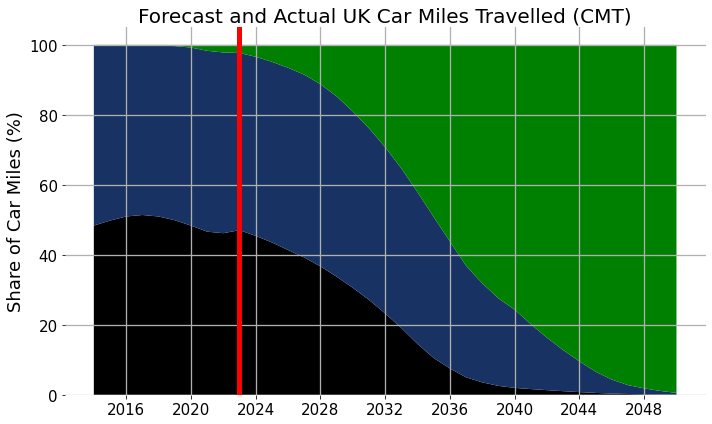

In [76]:
cdf_miles = pd.concat([
    historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].rename(columns={'diesel_vmt': 'Diesel', 'petrol_vmt' : 'Petrol', 'electric_vmt': 'Electric'}),
    forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].rename(columns={'diesel_vmt': 'Diesel', 'petrol_vmt' : 'Petrol', 'electric_vmt': 'Electric'})
])

cdf_miles_perc = 100*cdf_miles.div(cdf_miles.sum(axis=1), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

# historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(kind='area', ax=ax)

# forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(kind='area', ax=ax)

# cdf_miles_perc.plot(kind='area', ax=ax)

# ax.stackplot(cdf_miles_perc.index, cdf_miles['Diesel'], color='r')
ax.stackplot(cdf_miles_perc.index, cdf_miles_perc.Diesel,  cdf_miles_perc.Petrol, cdf_miles_perc.Electric, colors=['black', '#183363', 'green'], labels=['Diesel', 'Petrol', 'Electric'])
# ax.stackplot(cdf_miles_perc.index, cdf_miles_perc.Petrol, color='#183363')

ax.axvline(pd.Timestamp('2022-12-31'), color='red', label='Start of Forecast')
# ax.legend(facecolor='white', edgecolor='white')

# ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_ylabel('Share of Car Miles (%)')

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')



# ax.set_ylim(0, 300000000000)

plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')


In [77]:
cdf_miles = pd.concat([
    historical[[
        'diesel_vmt', 
        'petrol_vmt', 
        'electric_vmt'
    ]].rename(columns={
        'diesel_vmt': 'Diesel Observed',
        'petrol_vmt' : 'Petrol Observed',
        'electric_vmt': 'Electric Observed'
    }),
    forecast[[
        'diesel_vmt', 
        'petrol_vmt', 
        'electric_vmt'
    ]].rename(columns={
        'diesel_vmt': 'Diesel Forecast', 
        'petrol_vmt' : 'Petrol Forecast', 
        'electric_vmt': 'Electric Forecast'
    })
])

In [78]:
cdf_miles.reset_index(inplace=True)

In [79]:
# cdf_miles = cdf_miles / 1000000

In [80]:
# Prepare Parc Forecast
# cdf_miles.reset_index(inplace=True)
cdf_miles['dateOfForecast'] = pd.to_datetime((dt.today() - dateutil.relativedelta.relativedelta(months=1)).strftime('%Y-%m-01'))
# cdf_sel.reset_index(inplace=True)
cdf_miles.rename(columns={'Electric': 'BEV'}, inplace=True)
cdf_miles_long = cdf_miles.melt(id_vars=['index', 'dateOfForecast'], value_vars=[
    'Diesel Observed',
    'Petrol Observed',
    'Electric Observed',
    'Diesel Forecast',
    'Petrol Forecast',
    'Electric Forecast'
])

In [81]:
cdf_miles_long

index dateOfForecast           variable         value
0   2014-01-01     2023-06-01    Diesel Observed  1.199577e+11
1   2015-01-01     2023-06-01    Diesel Observed  1.240329e+11
2   2016-01-01     2023-06-01    Diesel Observed  1.275931e+11
3   2017-01-01     2023-06-01    Diesel Observed  1.275789e+11
4   2018-01-01     2023-06-01    Diesel Observed  1.238564e+11
..         ...            ...                ...           ...
217 2046-01-01     2023-06-01  Electric Forecast  1.888089e+11
218 2047-01-01     2023-06-01  Electric Forecast  1.925840e+11
219 2048-01-01     2023-06-01  Electric Forecast  1.948047e+11
220 2049-01-01     2023-06-01  Electric Forecast  1.965812e+11
221 2050-01-01     2023-06-01  Electric Forecast  1.979136e+11

[222 rows x 4 columns]

In [82]:
# Upload Parc Forecast
client = bigquery.Client()
table_id = 'zevMandate.carMilesForecast'

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField('index', 'DATE'),
        bigquery.SchemaField('variable', 'STRING'),
        bigquery.SchemaField('value', 'FLOAT'),
        bigquery.SchemaField('dateOfForecast', 'DATE')
    ]
)

job = client.load_table_from_dataframe(cdf_miles_long, table_id, job_config=job_config)

job.result()


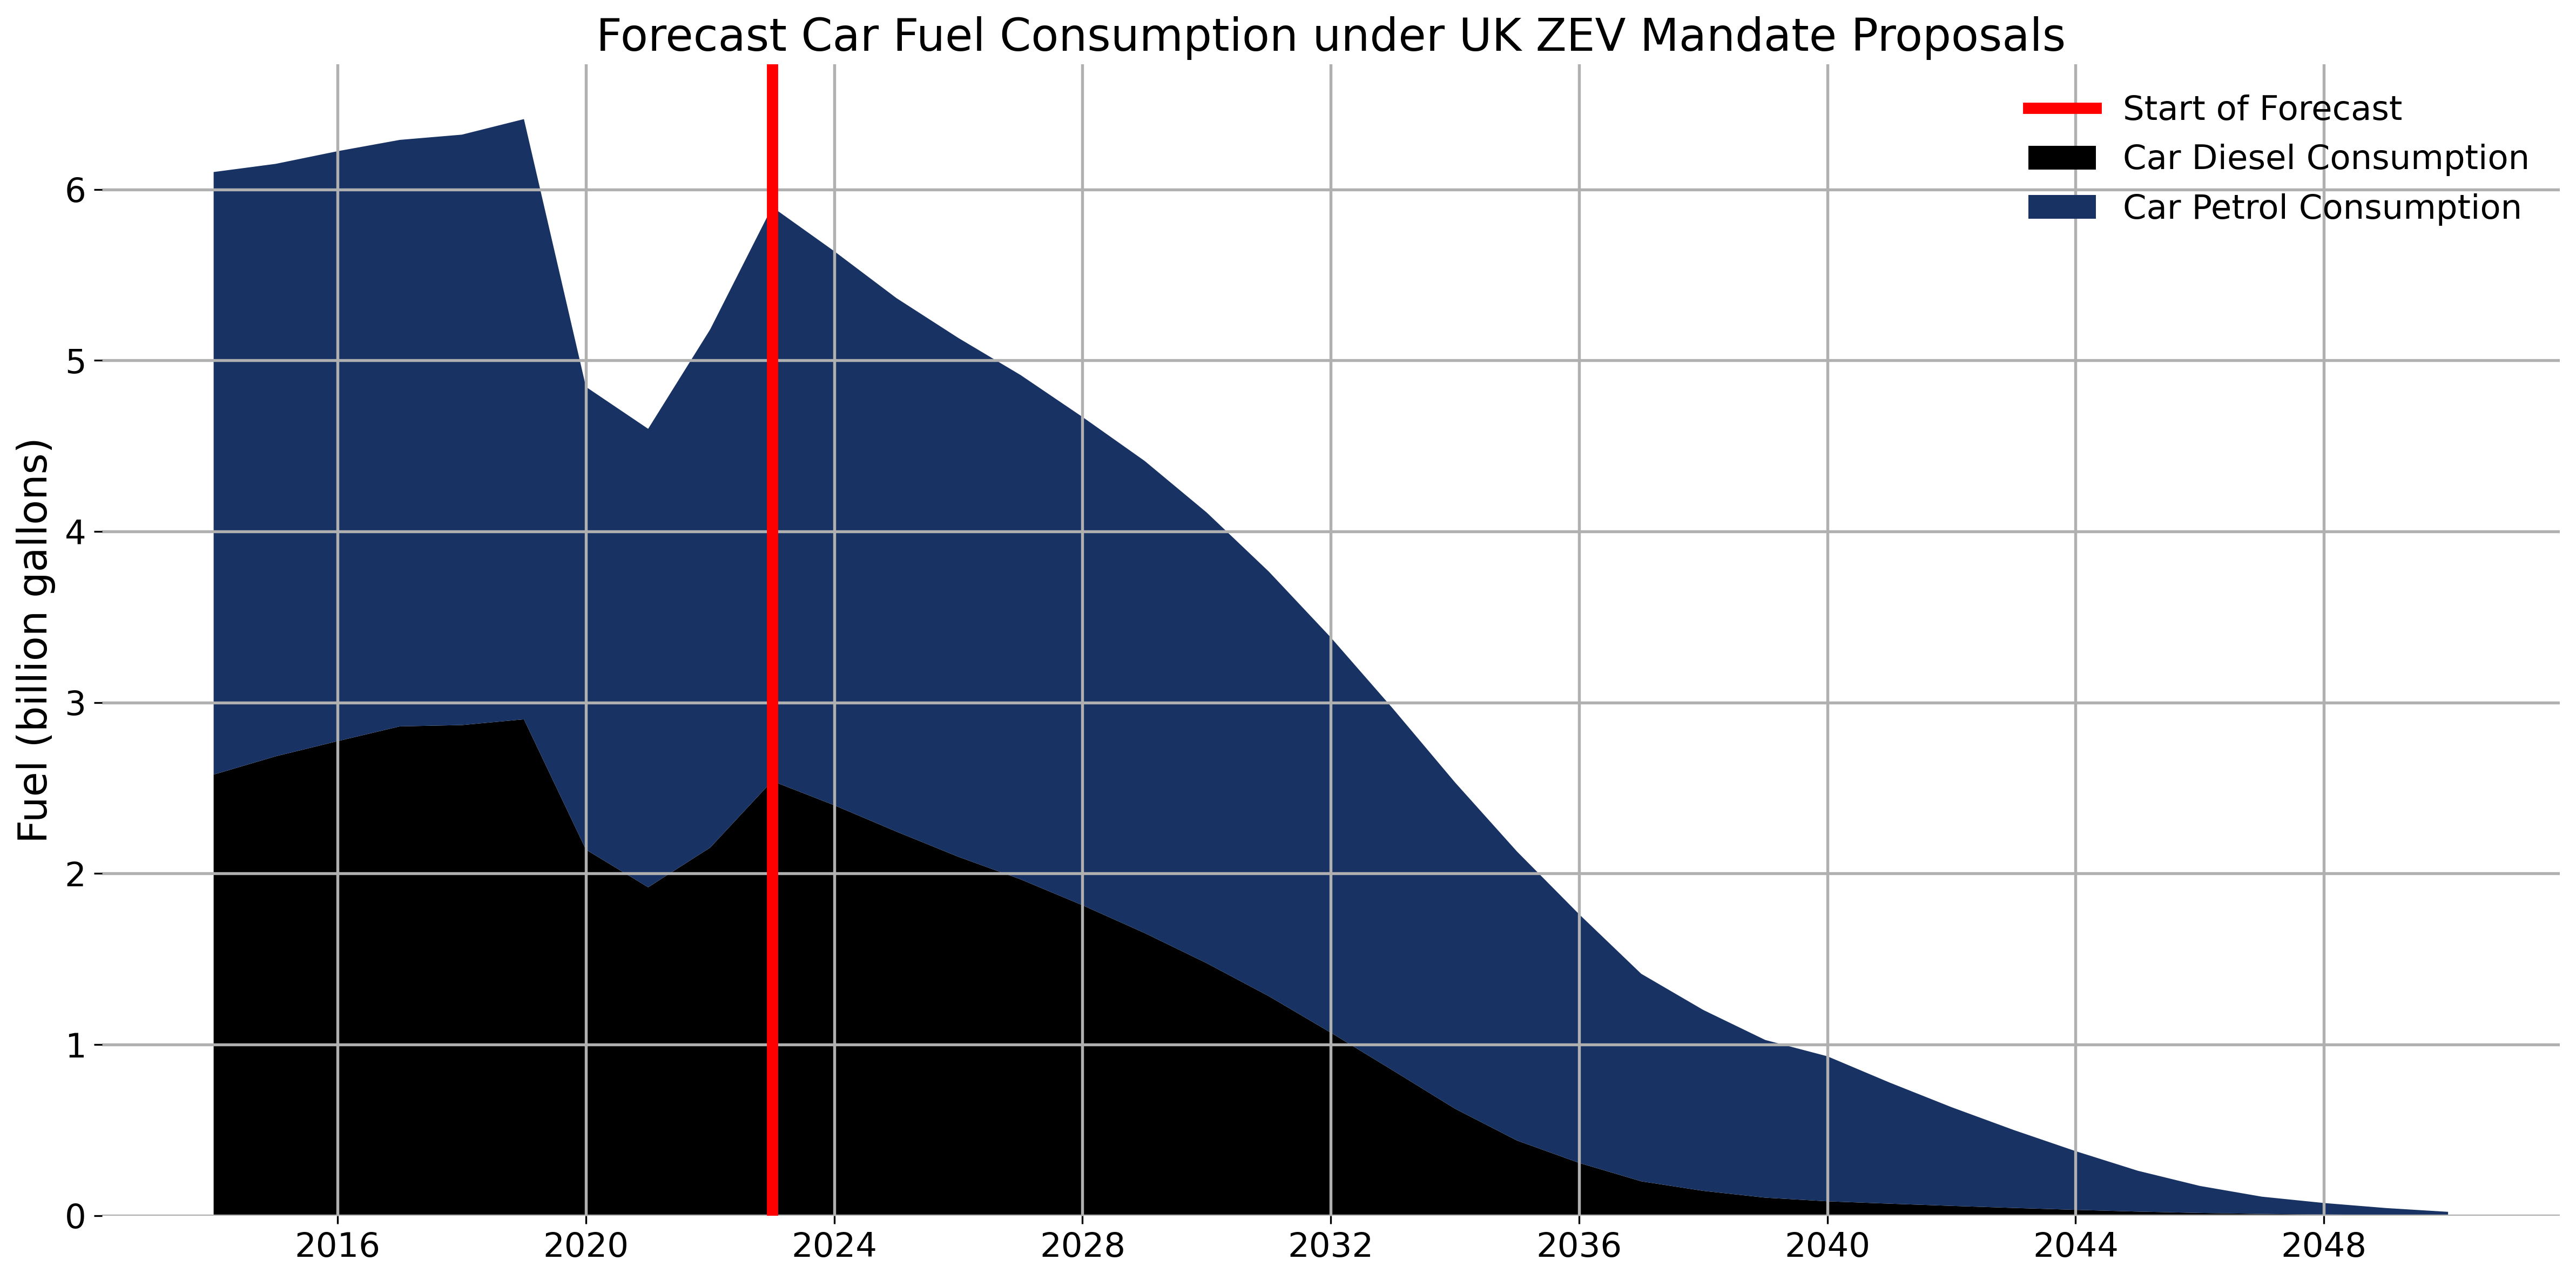

In [83]:
cdf_fuel = pd.concat([
    historical[['car_petrol_consumption_gallons', 'car_diesel_consumption_gallons']].rename(columns={'car_petrol_consumption_gallons': 'Petrol', 'car_diesel_consumption_gallons': 'Diesel'}),
    forecast[['car_petrol_consumption_gallons', 'car_diesel_consumption_gallons']].rename(columns={'car_petrol_consumption_gallons': 'Petrol', 'car_diesel_consumption_gallons': 'Diesel'})
])

fig, ax = plt.subplots(figsize=(16, 8), dpi=300)

ax.stackplot(cdf_fuel.resample('YS').last().index, cdf_fuel.Diesel/1000000000,  cdf_fuel.Petrol/1000000000, colors=['black', '#183363', 'green'], labels=['Car Diesel Consumption', 'Car Petrol Consumption'])
ax.axvline(pd.Timestamp('2022-12-31'), color='red', label='Start of Forecast')
ax.legend(loc='upper right', facecolor='white', edgecolor='white')
ax.set_ylabel('Fuel (billion gallons)')
ax.set_xlim()

ax.set_title('Forecast Car Fuel Consumption under UK ZEV Mandate Proposals')
plt.savefig('plots/fuel_projection_cars.png', transparent=False, bbox_inches='tight', dpi=300)


# ax.set_title('Forecast and Actual UK Cars on the Road')

Text(0.5, 0, 'Year')

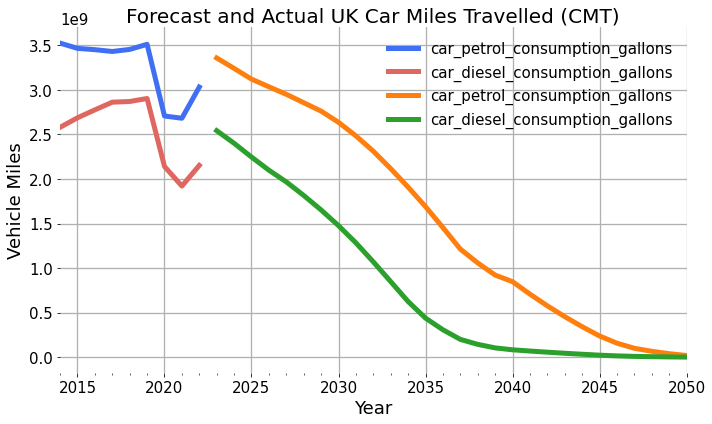

In [84]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['car_petrol_consumption_gallons', 'car_diesel_consumption_gallons']].dropna().plot( ax=ax)
forecast[['car_petrol_consumption_gallons', 'car_diesel_consumption_gallons']].dropna().plot( ax=ax)

# forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(ax=ax)

# ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')

ax.set_ylabel('Vehicle Miles')
ax.set_xlabel('Year')

# ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')

Text(0.5, 0, 'Year')

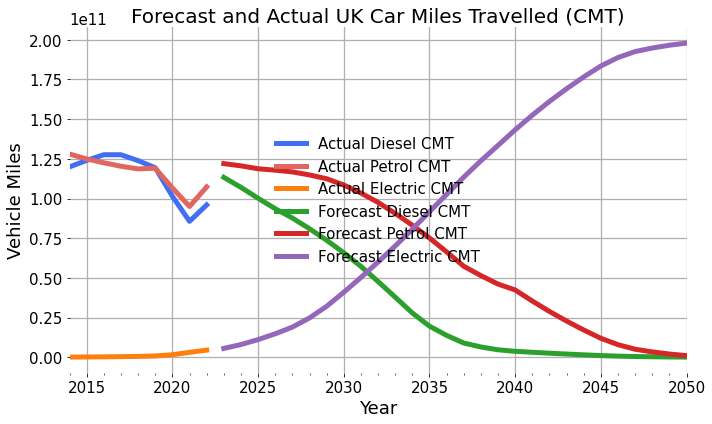

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot( ax=ax)

forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].dropna().plot(ax=ax)

ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')

ax.set_ylabel('Vehicle Miles')
ax.set_xlabel('Year')

# ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')


Text(0.5, 0, 'Year')

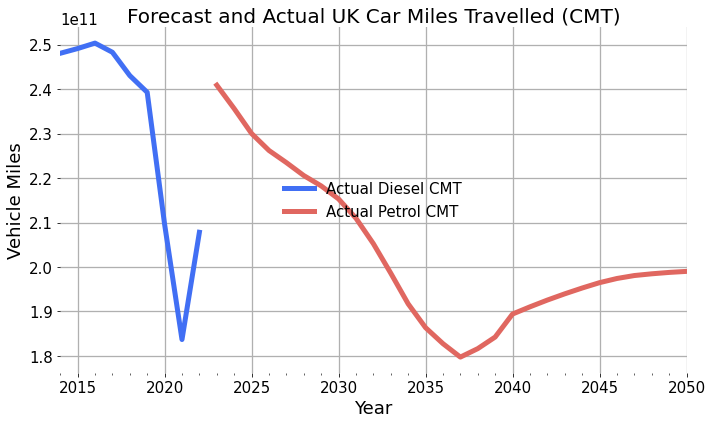

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].sum(axis=1).dropna().plot( ax=ax)

forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].sum(axis=1).dropna().plot(ax=ax)

ax.legend(['Actual Diesel CMT', 'Actual Petrol CMT', 'Actual Electric CMT', 'Forecast Diesel CMT', 'Forecast Petrol CMT', 'Forecast Electric CMT'])

ax.set_title('Forecast and Actual UK Car Miles Travelled (CMT)')

ax.set_ylabel('Vehicle Miles')
ax.set_xlabel('Year')

# ax.set_ylim(0, 300000000000)

# plt.savefig('plots/uk_vehicle_miles_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')

Text(0.5, 0, 'Year')

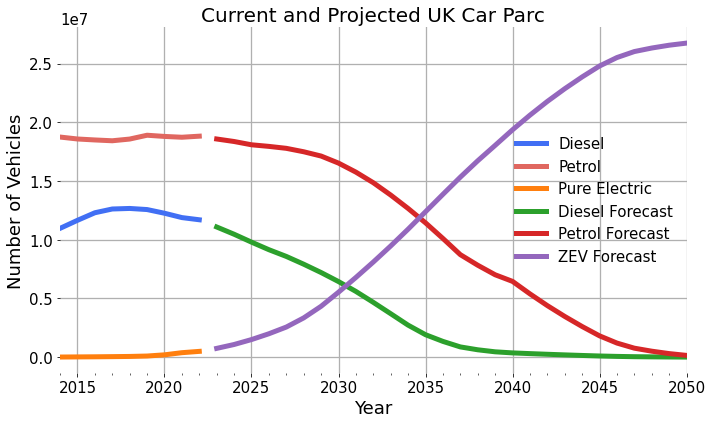

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))

historical[['Diesel', 'Petrol', 'Pure Electric']].plot(ax=ax)
forecast[['diesel', 'petrol', 'electric']].rename(columns={'diesel':'Diesel Forecast', 'petrol':'Petrol Forecast', 'electric':'ZEV Forecast'}).plot(ax=ax)

ax.set_title('Current and Projected UK Car Parc')
# ax.legend(['Diesel', 'Petrol', 'ZEV', 'Diesel Forecast', 'Petrol Forecast', 'ZEV Forecast'])

ax.set_ylabel('Number of Vehicles')
ax.set_xlabel('Year')

# plt.savefig('plots/vehicle_parc_past_future.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')


In [88]:
start_emissions = historical[['petrol_emissions', 'diesel_emissions']].sum(axis=1).iloc[-1]
end_emissions = forecast[['petrol_emissions', 'diesel_emissions']].sum(axis=1).iloc[-1]

print("Total emissions saved: {}".format(start_emissions - end_emissions))
print("Emissions eliminated by 2050: {}%".format(round(100*(start_emissions - end_emissions) / start_emissions, ndigits=2)))

Total emissions saved: 58985135165.547134
Emissions eliminated by 2050: 99.56%


In [89]:
round(100*(start_emissions - end_emissions) / start_emissions, ndigits=2)

99.56

### Motorist spending on fuel

In [90]:
petrol_price_ppl = 146.63
diesel_price_ppl = 164.26

petrol_price_ppg = petrol_price_ppl / 0.21997
diesel_price_ppg = diesel_price_ppl / 0.21997

cdf_fuel['petrol_spend_p'] = cdf_fuel.Petrol.apply(lambda x: x*petrol_price_ppg)
cdf_fuel['diesel_spend_p'] = cdf_fuel.Diesel.apply(lambda x: x*diesel_price_ppg)

cdf_fuel['spend_£'] = cdf_fuel.apply(lambda row: (row.petrol_spend_p + row.diesel_spend_p)/100, axis=1)

<AxesSubplot:>

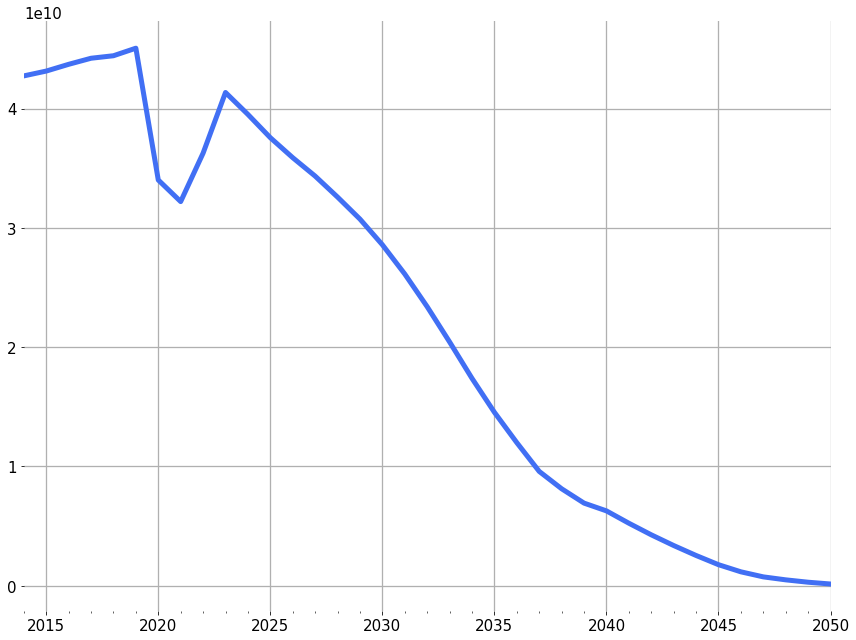

In [91]:
cdf_fuel['spend_£'].plot()

# High Mileage Drivers

In [92]:
%%bigquery ds --project rugged-baton-283921
SELECT avg_mileage
FROM `rugged-baton-283921.Index.Annual_mileage_fueltype_emissions` 
WHERE typeApproval = 'M1'
AND completedYear = 2022
AND avg_mileage < 80000

Downloading: 100%|██████████| 26286763/26286763 [00:14<00:00, 1866968.01rows/s]


In [93]:
ds['decile'] = pd.qcut(ds.avg_mileage, q=10, labels=list(range(0, 10)))

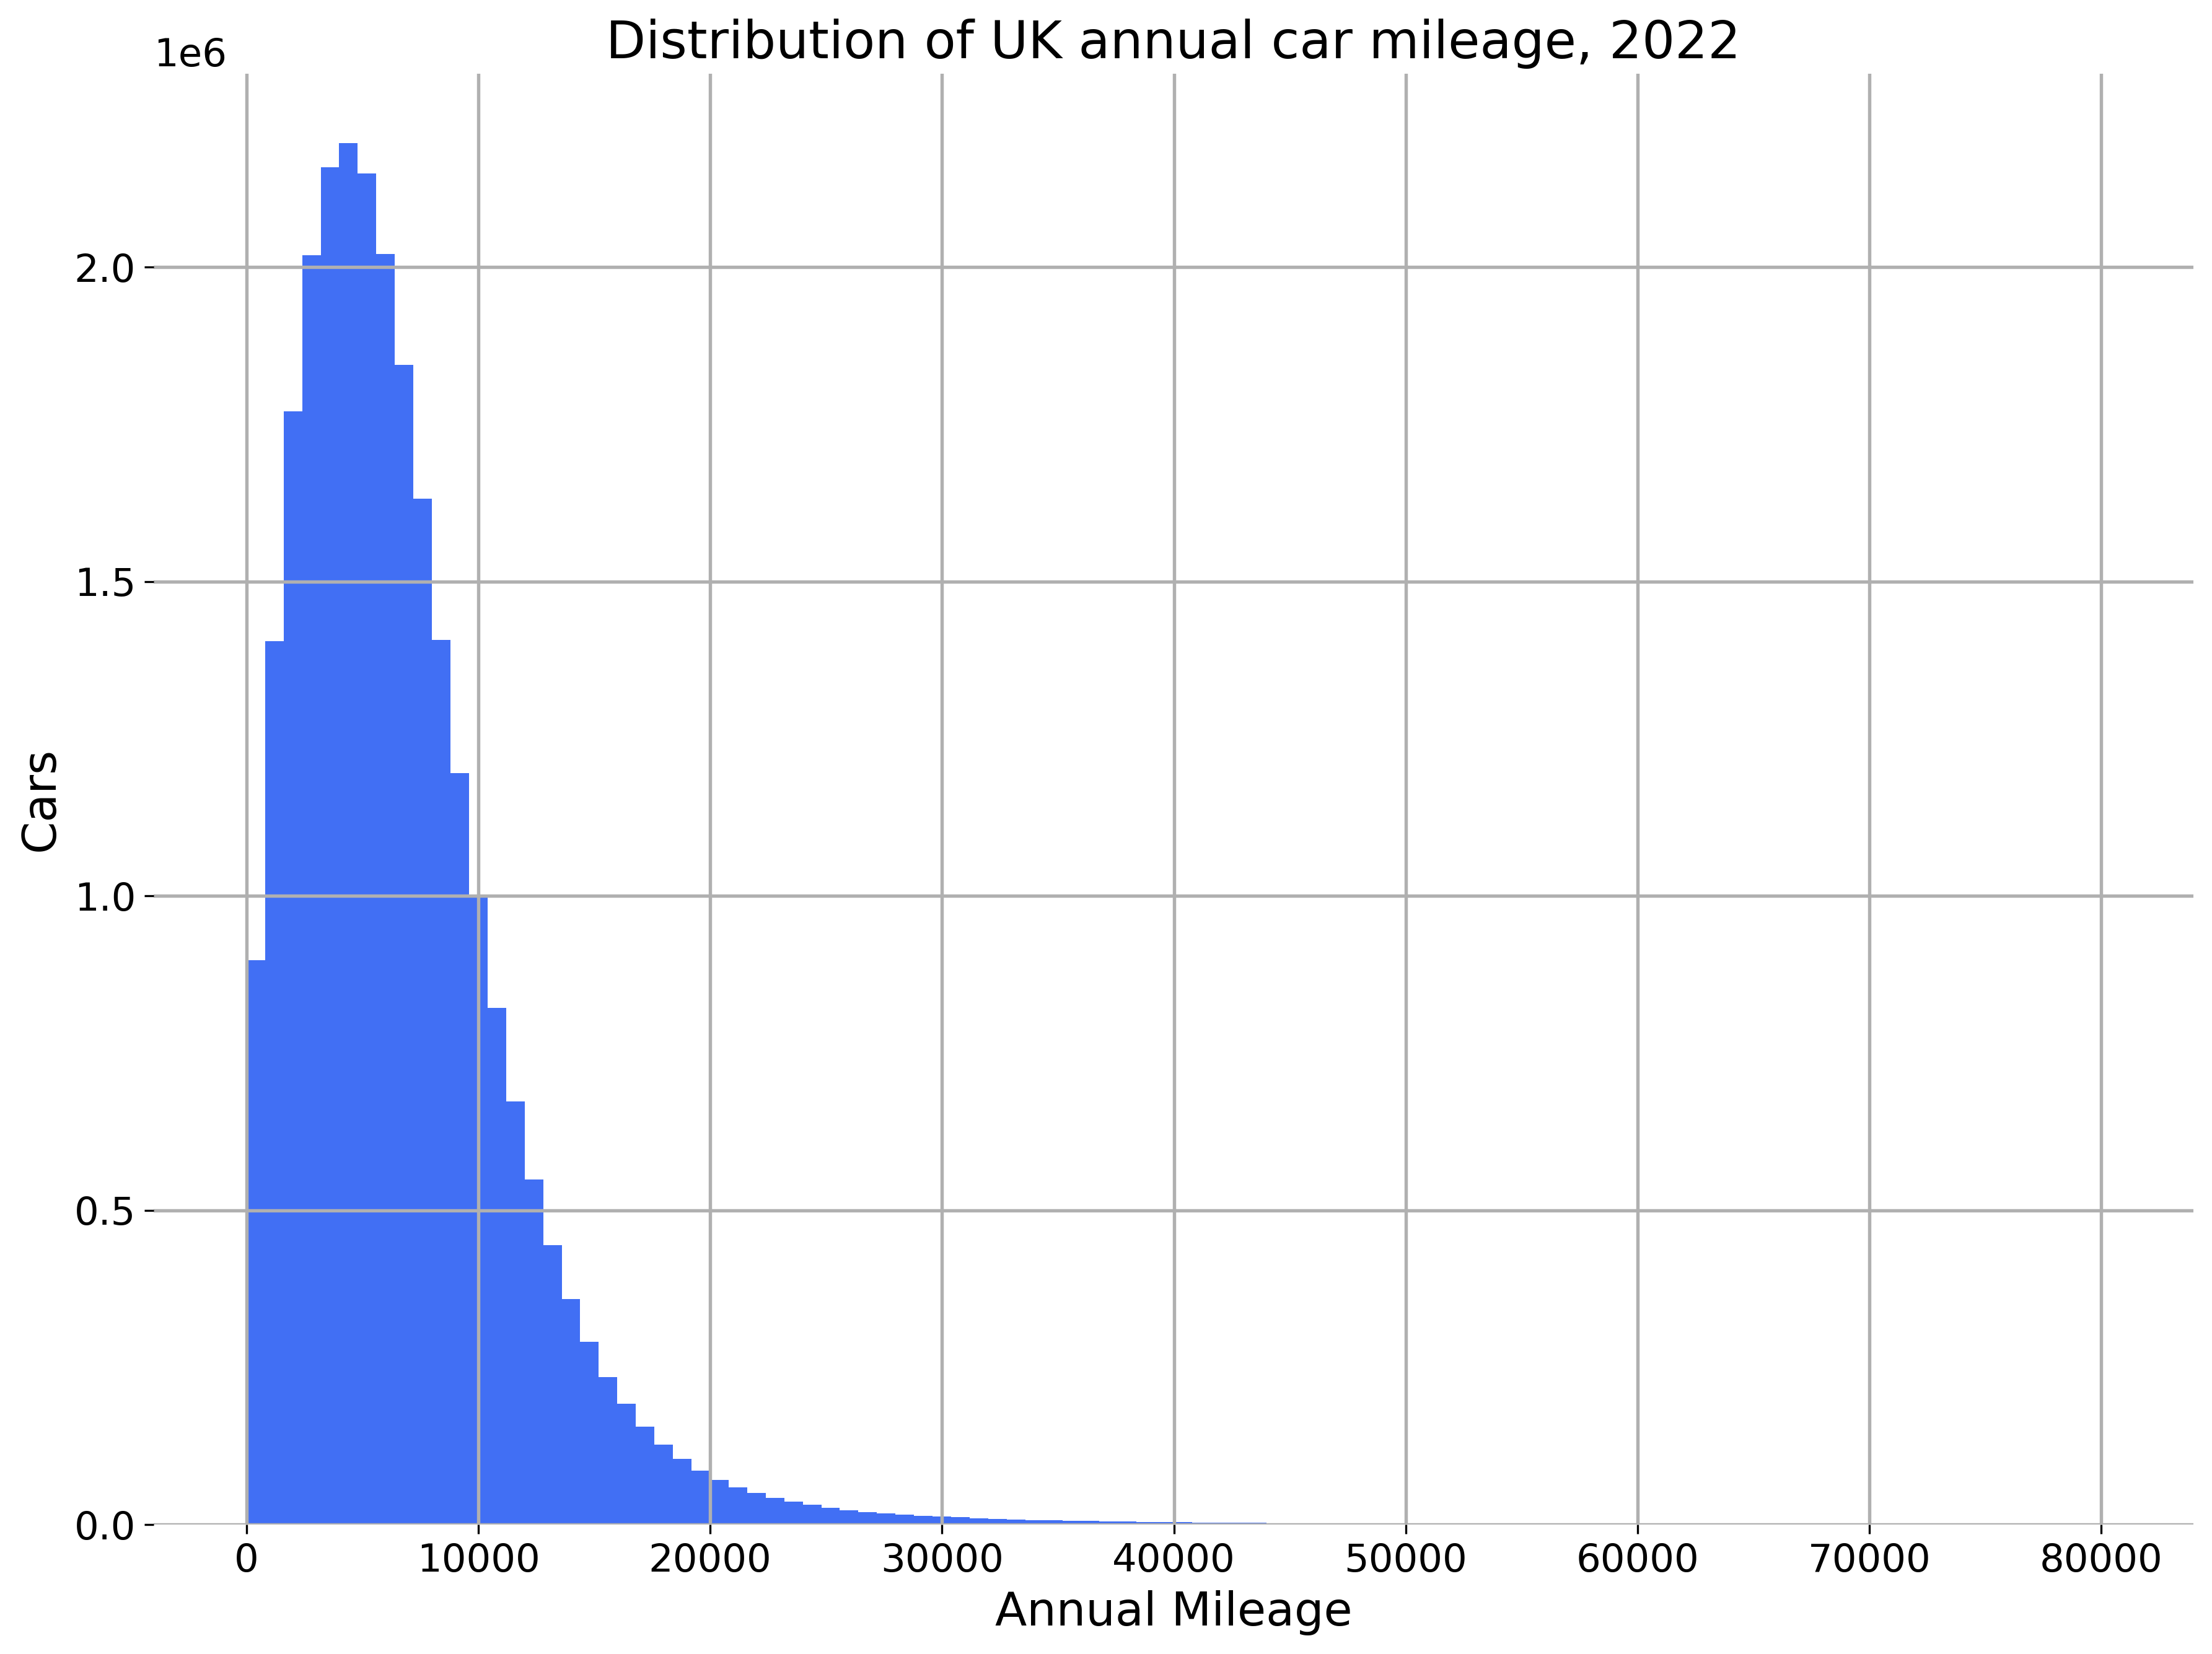

In [94]:
fig, ax = plt.subplots(dpi=300)

ds.avg_mileage.hist(bins=100, ax=ax)

ax.set_title('Distribution of UK annual car mileage, 2022')
ax.set_ylabel('Cars')
ax.set_xlabel('Annual Mileage')

plt.savefig('plots/car_mileage_dist.png', dpi=300, transparent=False, bbox_inches='tight', facecolor='white')

plt.show()

In [95]:
mileage_deciles = ((ds.groupby('decile').sum()/ds.avg_mileage.sum()).avg_mileage.tolist())[::-1]

In [96]:
mileage_deciles

[0.2615286331234223,
 0.16298107667772038,
 0.13157428207732946,
 0.11021935524596768,
 0.09309997960596376,
 0.07801877452104192,
 0.06381878392308477,
 0.04962027160810305,
 0.034320702458256275,
 0.01481814075909039]

In [97]:
def hmd_model(bev_share, car_vmt = 255000000000):
    
    # Set the total number of cars, and total VMT
    # car_vmt = 250000000000 This is now defined as an input each time the model is run.
    cars = 33000000

    # Set the BEV percentage as a fraction of 1, then calculate the number of ICE cars
    bev_perc = bev_share
    bevs = cars * bev_perc
    ice_cars = cars-bevs

    # Let's work with lists of deciles
    decile = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # This list contains the share of total car miles driven by cars in each decile
    mileage_dec = mileage_deciles

    # Calculate share total VMT and the average VMT for each decile
    total_mileage_deciles = [(x*car_vmt) for x in mileage_dec]
    average_mileages_deciles = [x/(cars/10) for x in total_mileage_deciles]

    # Calculate the total number of cars in each decile
    cars_in_decile = [cars/10 for x in decile]

    # Now we cascade the BEVs down the deciles, starting with the highest mileage first. 
    bevs_in_deciles = []
    for i in decile:
        if bevs <= cars_in_decile[i]:
            bevs_in_deciles.append(bevs)
            bevs -= bevs
        elif bevs > cars_in_decile[i]:
            bevs_in_deciles.append(cars_in_decile[i])
            bevs -= cars_in_decile[i]


    # Now we calculate the remaining ICEs in each decile
    ices_in_deciles = []

    for i in decile:
        ices_in_deciles.append(cars_in_decile[i] - bevs_in_deciles[i])

    # Now let's calculate the total mileages for each powertrain
    ice_vmt = 0
    bev_vmt = 0

    for i in decile:
        bev_vmt += bevs_in_deciles[i] * average_mileages_deciles[i]
        ice_vmt += ices_in_deciles[i] * average_mileages_deciles[i]
        
    return ice_vmt, bev_vmt

In [98]:
car_vmt = 255000000000

bev_share = list(range(1, 101))
ice_miles = []
bev_miles = []
bev_miles_baseline = []
for e in bev_share:
    x, y = hmd_model(e/100)
    b = car_vmt*(e/100)
    ice_miles.append(x)
    bev_miles.append(y)
    bev_miles_baseline.append(b)

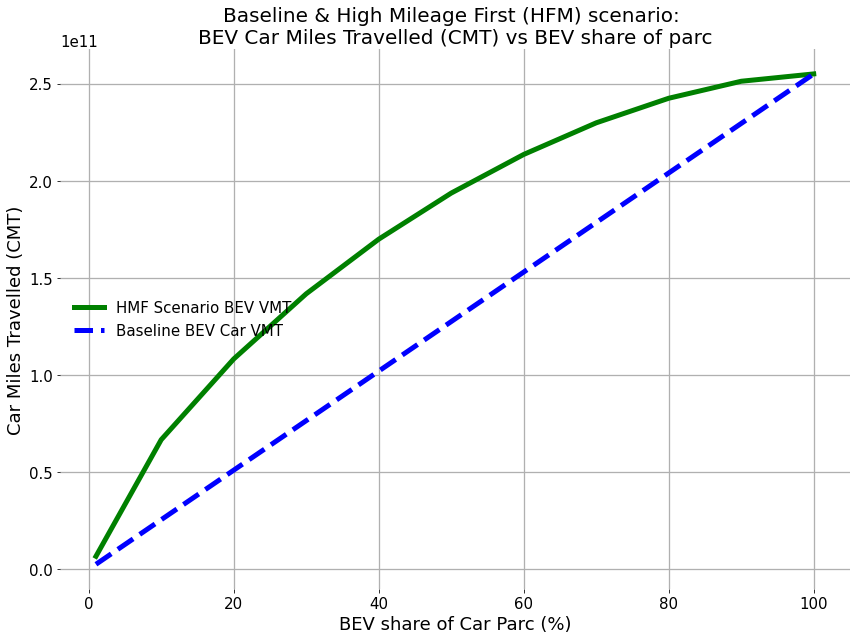

In [112]:
fig, ax = plt.subplots()

ax.plot(bev_share, bev_miles, c='green', label='HMF Scenario BEV VMT')
# ax.plot(bev_share, ice_miles, color='black', label='HMF Scenario ICE share of VMT')
ax.plot(bev_share, bev_miles_baseline, label='Baseline BEV Car VMT', color='blue', linestyle='dashed')
# ax.plot(bev_share, [car_vmt-x for x in bev_miles_baseline], label='Baseline ICE Car VMT')
ax.legend(loc='center left')

ax.set_xlabel('BEV share of Car Parc (%)')
ax.set_ylabel('Car Miles Travelled (CMT)')
ax.set_title('Baseline & High Mileage First (HFM) scenario: \nBEV Car Miles Travelled (CMT) vs BEV share of parc')

plt.savefig('plots/mileage_saving_hmf.png', transparent=False, bbox_inches='tight', dpi=300, facecolor='white')

plt.show()

In [100]:
bev_perc_parc = (dfp.electric / dfp[['diesel', 'petrol', 'electric']].sum(axis=1)).values.tolist()

In [101]:
annual_car_vmt = forecast[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].sum(axis=1).tolist()

In [102]:
forecast_hmf = forecast.copy()
forecast_hmf['total_car_vmt'] = forecast_hmf[['diesel_vmt', 'petrol_vmt', 'electric_vmt']].sum(axis=1).tolist()
forecast_hmf['bev_parc_perc'] = forecast_hmf.apply(lambda row: row['electric'] / (row['diesel'] + row['petrol'] + row['electric']), axis=1)

In [103]:
forecast_hmf['hmf_ice_miles'] = forecast_hmf.apply(lambda row: hmd_model(row['bev_parc_perc'], row['total_car_vmt'])[0], axis=1)
forecast_hmf['hmf_bev_miles'] = forecast_hmf.apply(lambda row: hmd_model(row['bev_parc_perc'], row['total_car_vmt'])[1], axis=1)

In [104]:
forecast_hmf['hmf_ice_miles_petrol'] = forecast_hmf.apply(lambda row: row['hmf_ice_miles'] * (row['petrol'] / (row['diesel'] + row['petrol'])), axis=1)
forecast_hmf['hmf_ice_miles_diesel'] = forecast_hmf.apply(lambda row: row['hmf_ice_miles'] * (row['diesel'] / (row['diesel'] + row['petrol'])), axis=1)

In [105]:
forecast_hmf['hmf_car_petrol_consumption_gallons'] = forecast_hmf.apply(lambda row: row.hmf_ice_miles_petrol / row.petrol_economy, axis=1)
forecast_hmf['hmf_car_diesel_consumption_gallons'] = forecast_hmf.apply(lambda row: row.hmf_ice_miles_diesel/ row.diesel_economy, axis=1)

forecast_hmf['hmf_petrol_consumption'] = forecast_hmf.hmf_car_petrol_consumption_gallons.apply(lambda x: ((x/219.969)*.98)/1000)
forecast_hmf['hmf_diesel_consumption'] = forecast_hmf.hmf_car_diesel_consumption_gallons.apply(lambda x: ((x/219.969)*.86)/1000)

forecast_hmf['hmf_diesel_emissions'] = forecast_hmf.hmf_diesel_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.23686)
forecast_hmf['hmf_petrol_emissions'] = forecast_hmf.hmf_petrol_consumption.apply(lambda x: ((1000*x)*11629.9998357937)*.22980)

In [106]:
forecast_hmf['hmf_annual_saving'] = forecast_hmf[['petrol_emissions', 'diesel_emissions']].sum(axis=1) - forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].sum(axis=1)

In [107]:
bridge_values = [
    historical[['diesel_emissions', 'petrol_emissions']].resample('YS').first().sum(axis=1)[-1]/1000000,
    forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].resample('YS').first().sum(axis=1)[0]/1000000
]

bridge_index = [
    historical[['diesel_emissions', 'petrol_emissions']].resample('YS').first().sum(axis=1).index[-1],
    forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].resample('YS').first().sum(axis=1).index[0]
]

In [108]:
forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].sum(axis=1)[0]

66560811345.24347

In [109]:
# emissions_since_1990 = em[(em.variable <'2015-01-01') & (em.IPCC_name == '1A3bi_Cars')].pivot(index='variable', columns='IPCC_name', values='value').resample('Y').last().dropna()['1A3bi_Cars']

In [110]:
# fig, ax=plt.subplots(figsize=(12, 6))

# lw=1.5

# historic_emissions = historical[['diesel_emissions', 'petrol_emissions']].sum(axis=1)/1000000
# hmf_emissions = forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].sum(axis=1)/1000000
# baseline_emissions = forecast_hmf[['petrol_emissions', 'diesel_emissions']].sum(axis=1)/1000000

# ax.plot(emissions_since_1990, linewidth=lw, c='blue')
# ax.plot(bridge_index, bridge_values, c='blue', linestyle='dashed', linewidth=lw)
# ax.plot(historic_emissions, label='Historic Emissions', c='blue', linewidth=lw)
# ax.plot(hmf_emissions, label='HMF Emissions', c='red', linewidth=lw)
# ax.plot(baseline_emissions, label='Baseline Emissions', c='purple', linewidth=lw)

# ax.fill_between(x=baseline_emissions.index.tolist(), y2=hmf_emissions, y1=baseline_emissions, color='gray')

# total_saving = round(baseline_emissions.sum() - hmf_emissions.sum(), ndigits=2)

# ax.text(s = 'Grey area: {} kilotonnes CO2e'.format(total_saving), x=17000, y=15000, fontsize=14)

# # pd.concat([df[['diesel_emissions', 'petrol_emissions']].dropna(),
# # df_sel[['diesel_emissions', 'petrol_emissions']]]).sum(axis=1).plot(ax=ax, label='Calculated Emissions')
# # dfp[['diesel_emissions', 'petrol_emissions']].sum(axis=1).plot(ax=ax, label='Forecast Emissions kgCO2e')

# ax.legend(loc='upper right')
# ax.set_ylabel('Emissions kilotonnes CO2e')
# ax.set_xlabel('Year')
# ax.set_title('Possible Additional Emissions Reductions from Cars')


# # ax.set_ylim(0, 4300000000)

# plt.savefig('plots/hmf_car_emissions.png', transparent=False, bbox_inches='tight', dpi=300, facecolor='white')

# plt.show()

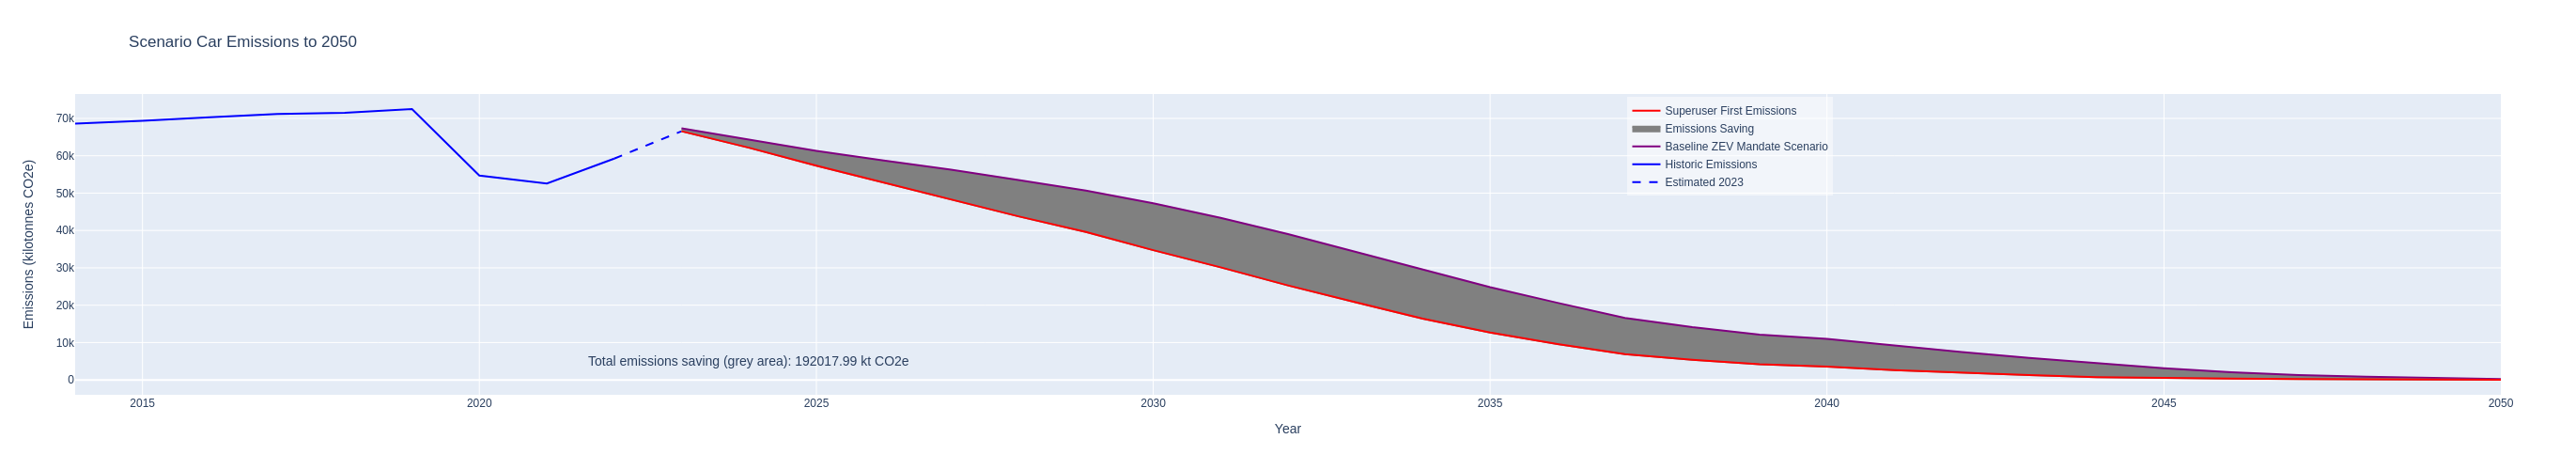

In [111]:
lw = 1.5

historic_emissions = historical[['diesel_emissions', 'petrol_emissions']].resample('YS').last().sum(axis=1) / 1000000
hmf_emissions = forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].resample('YS').last().sum(axis=1) / 1000000
baseline_emissions = forecast_hmf[['petrol_emissions', 'diesel_emissions']].resample('YS').last().sum(axis=1) / 1000000

fig = go.Figure()

fig.add_trace(go.Scatter(x=bridge_index, y=bridge_values, mode='lines', line=dict(color='blue', dash='dash'), name='Estimated 2023'))
fig.add_trace(go.Scatter(x=historic_emissions.index, y=historic_emissions, mode='lines', line=dict(color='blue'), name='Historic Emissions'))

fig.add_trace(go.Scatter(x=baseline_emissions.index, y=baseline_emissions, mode='lines', line=dict(color='purple'), name='Baseline ZEV Mandate Scenario'))

fig.add_trace(go.Scatter(
    x=baseline_emissions.index.tolist(), 
    y=hmf_emissions, 
    fill='tonexty', 
    line_color='gray',
    fillcolor='gray', 
    name='Emissions Saving'))

total_saving = round(baseline_emissions.sum() - hmf_emissions.sum(), ndigits=2)
fig.add_annotation(x='2024-01-01', y=5000, text='Total emissions saving (grey area): {} kt CO2e'.format(total_saving), showarrow=False, font=dict(size=14))

fig.add_trace(go.Scatter(x=hmf_emissions.index, y=hmf_emissions, mode='lines', line=dict(color='red'), name='Superuser First Emissions'))

fig.update_layout(
    title='Scenario Car Emissions to 2050',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Emissions (kilotonnes CO2e)'),
    legend=dict(
        # x=1, 
        # y=1, 
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.64,
        bgcolor='rgba(255, 255, 255, 0.5)'),
    autosize=False,
    width=800,
    height=500
)

fig.write_image('plots/hmf_car_emissions.png', format='png', width=800, height=500, scale=2)
fig.write_html("plots/test.html")
fig.show()

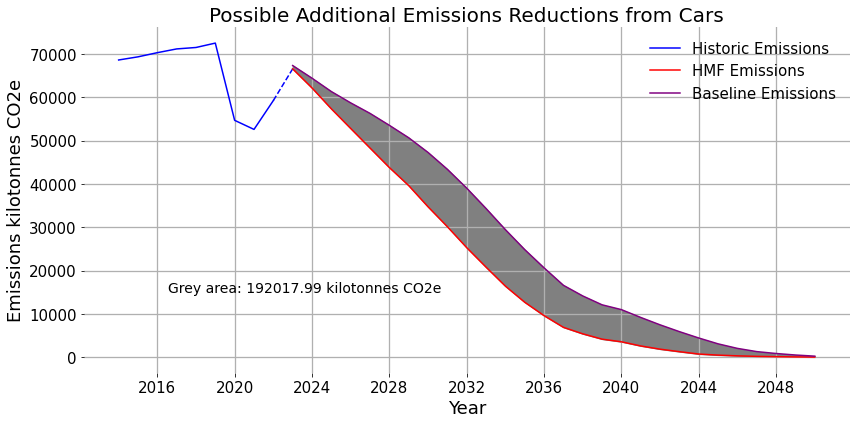

In [124]:
fig, ax=plt.subplots(figsize=(12, 6))

lw=1.5

historic_emissions = historical[['diesel_emissions', 'petrol_emissions']].resample('YS').last().sum(axis=1)/1000000
hmf_emissions = forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].resample('YS').last().sum(axis=1)/1000000
baseline_emissions = forecast_hmf[['petrol_emissions', 'diesel_emissions']].resample('YS').last().sum(axis=1)/1000000

ax.plot(bridge_index, bridge_values, c='blue', linestyle='dashed', linewidth=lw)
ax.plot(historic_emissions, label='Historic Emissions', c='blue', linewidth=lw)
ax.plot(hmf_emissions, label='HMF Emissions', c='red', linewidth=lw)
ax.plot(baseline_emissions, label='Baseline Emissions', c='purple', linewidth=lw)

ax.fill_between(x=baseline_emissions.index.tolist(), y2=hmf_emissions, y1=baseline_emissions, color='gray')

total_saving = round(baseline_emissions.sum() - hmf_emissions.sum(), ndigits=2)

ax.text(s = 'Grey area: {} kilotonnes CO2e'.format(total_saving), x=17000, y=15000, fontsize=14)

# pd.concat([df[['diesel_emissions', 'petrol_emissions']].dropna(),
# df_sel[['diesel_emissions', 'petrol_emissions']]]).sum(axis=1).plot(ax=ax, label='Calculated Emissions')
# dfp[['diesel_emissions', 'petrol_emissions']].sum(axis=1).plot(ax=ax, label='Forecast Emissions kgCO2e')

ax.legend(loc='upper right')
ax.set_ylabel('Emissions kilotonnes CO2e')
ax.set_xlabel('Year')
ax.set_title('Possible Additional Emissions Reductions from Cars')


# ax.set_ylim(0, 4300000000)

# plt.savefig('plots/hmf_car_emissions.png', transparent=False, bbox_inches='tight', dpi=300, facecolor='white')

plt.show()

In [125]:
baseline_emissions

2023-01-01    67327.994023
2024-01-01    64408.667520
2025-01-01    61320.792692
2026-01-01    58707.611944
2027-01-01    56285.689925
2028-01-01    53533.479789
2029-01-01    50656.745389
2030-01-01    47267.291048
2031-01-01    43380.972444
2032-01-01    39034.663388
2033-01-01    34326.702096
2034-01-01    29449.918128
2035-01-01    24848.053067
2036-01-01    20637.095607
2037-01-01    16608.299811
2038-01-01    14154.340577
2039-01-01    12108.581742
2040-01-01    10999.004689
2041-01-01     9187.661046
2042-01-01     7485.434156
2043-01-01     5914.148536
2044-01-01     4451.980573
2045-01-01     3098.929362
2046-01-01     2051.407262
2047-01-01     1309.411803
2048-01-01      872.943890
2049-01-01      523.770680
2050-01-01      261.888138
Freq: AS-JAN, dtype: float64

In [126]:
hmf_emissions

2023-01-01    66560.811345
2024-01-01    62161.667784
2025-01-01    57331.039991
2026-01-01    52804.104231
2027-01-01    48292.998567
2028-01-01    43794.175029
2029-01-01    39622.039592
2030-01-01    34729.313935
2031-01-01    30138.057211
2032-01-01    25304.244215
2033-01-01    20796.979637
2034-01-01    16420.400836
2035-01-01    12703.802132
2036-01-01     9614.054550
2037-01-01     6910.861954
2038-01-01     5411.086766
2039-01-01     4186.979885
2040-01-01     3574.705402
2041-01-01     2613.125573
2042-01-01     1872.880483
2043-01-01     1292.522012
2044-01-01      749.005548
2045-01-01      499.232955
2046-01-01      331.179709
2047-01-01      211.707312
2048-01-01      141.261945
2049-01-01       84.816855
2050-01-01       42.430953
Freq: AS-JAN, dtype: float64

In [127]:
# Export data for flourish viz

# bridge_index, bridge_values,
(pd.concat([historical[['diesel_emissions', 'petrol_emissions']].sum(axis=1),
forecast_hmf[['hmf_petrol_emissions', 'hmf_diesel_emissions']].sum(axis=1),
forecast_hmf[['petrol_emissions', 'diesel_emissions']].sum(axis=1)], axis=1).rename(
    columns={
        0: 'Historic Car Emissions', 
        1: 'Superuser First', 
        2: 'Baseline ZEV Mandate'
    }
)/1000000).to_csv('hmf_vs_baseline.csv')


In [128]:
forecast_hmf['hmf_annual_saving'].sum()

192017992917.7806

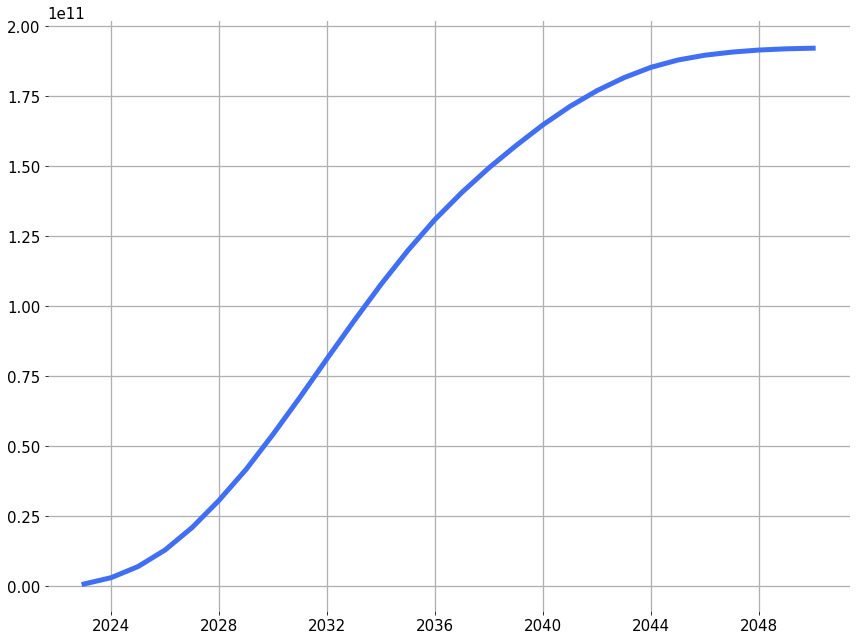

In [129]:
fig, ax = plt.subplots()

ax.plot(forecast_hmf['hmf_annual_saving'].cumsum(), label='HMF Emissions Savings')
# ax.plot(forecast_hmf[['petrol_emissions', 'diesel_emissions']].sum(axis=1), label='Baseline Emissions')

In [130]:
years = forecast.index
ice_miles = []
bev_miles = []
bev_miles_baseline = []
for i, e in enumerate(bev_perc_parc):
    x, y = hmd_model(e, car_vmt = annual_car_vmt[i])
    b = annual_car_vmt[i]*(e)
    # im = 
    ice_miles.append(x)
    bev_miles.append(y)
    bev_miles_baseline.append(b)

In [131]:
# forecast_hmf['hmf_ice']

In [132]:
ml = pd.DataFrame(
    index = years,
    data = {
        'bev_perc': bev_perc_parc,
        'hmf_ice_miles': ice_miles,
        'hmf_bev_miles': bev_miles,
        'baseline_bev_miles': bev_miles_baseline
    }
)

<AxesSubplot:>

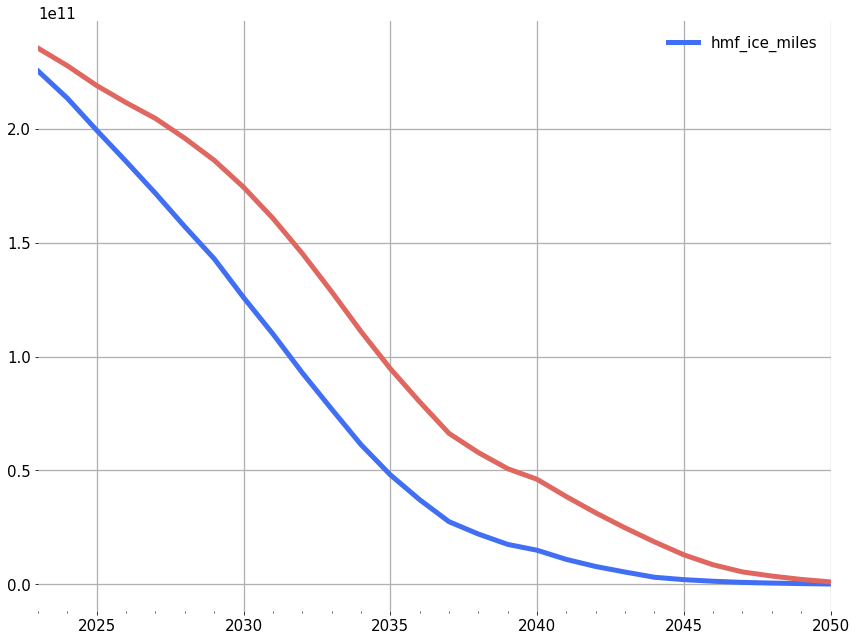

In [133]:
fig, ax = plt.subplots()

ml[['hmf_ice_miles']].plot(ax=ax)

forecast[['diesel_vmt', 'petrol_vmt']].sum(axis=1).plot(ax=ax)

## Electrification of different mileage deciles


In [134]:
import plotly.express as px

color_discrete_map = {'Diesel': 'black', 'Petrol': '#183363',
                      'Gas': '#183363', 'Hybrid': '#244d8c',
                      'Pure electric': 'green'}

In [ ]:
%%bigquery ds --project rugged-baton-283921
SELECT completedYear, avg_mileage, fuelType
FROM `rugged-baton-283921.Index.Annual_mileage_fueltype_emissions` 
WHERE typeApproval = 'M1'
AND completedYear > 2006
AND avg_mileage < 80000

Downloading:  52%|█████▏    | 146106319/281367723 [01:56<02:49, 799821.48rows/s] 

In [ ]:
ys = ds.completedYear.unique().tolist()

In [ ]:
dfs = []

for y in ys:
    tdf = ds[ds.completedYear == y]
    tdf['decile'] = pd.qcut(tdf.avg_mileage, q=10, labels=list(range(0, 10)))
    tdf = tdf.groupby(['completedYear', 'decile', 'fuelType']).count().reset_index()
    tdf = tdf.pivot(index='decile', columns='fuelType', values='avg_mileage')
    tdf = round(100*tdf.div(tdf.sum(axis=1), axis=0), ndigits=2)
    tdf = tdf.reset_index().melt(id_vars='decile')
    tdf['year'] = y
    dfs.append(tdf)

In [ ]:
dsc = pd.concat(dfs)

In [ ]:
dsc = dsc[dsc.year > 2006]

In [ ]:
# ds.groupby(['decile', 'fuelType']).count().reset_index().pivot(index='decile', columns='fuelType', values='avg_mileage')

In [ ]:
# ds_ft = ds.groupby(['', 'decile', 'fuelType']).count().reset_index()

In [ ]:
# ds_ft = ds_ft.pivot(index='decile', columns='fuelType', values='avg_mileage')

In [ ]:
# ds_ft = round(100*ds_ft.div(ds_ft.sum(axis=1), axis=0), ndigits=2)
# ds_ft.to_csv('out.csv')
# ds_ft

In [ ]:
fig = px.bar(dsc[dsc.fuelType.isin(['Pure electric'])], x='decile', y='value', color='fuelType', barmode='group', animation_frame='year')

fig.update_layout(
    title='Share of Fueltypes in Annual Mileage Decile',
    xaxis=dict(title='Annual Mileage Decile (0 = least miles per year, 9 = most miles per year)'),
    yaxis=dict(title='Share of all vehicles (%)'),
    # legend=dict(
    #     # x=1, 
    #     # y=1, 
    #     yanchor="top",
    #     y=0.99,
    #     xanchor="left",
    #     x=0.64,
    #     bgcolor='rgba(255, 255, 255, 0.5)'),
    autosize=True,
    width=800,
    height=500,
    yaxis_range=[0, 3]
    
)

fig.show()

In [ ]:
# r = np.random.RandomState(42)

# # sample data
# df = pd.DataFrame(
#     {
#         "step": np.repeat(np.arange(0, 8), 10),
#         "x": np.tile(np.linspace(0, 9, 10), 8),
#         "y": r.uniform(0, 5, 80),
#     }
# )

# # smaple plotly animated figure
# fig = px.bar(df, x="x", y="y", animation_frame="step")

# generate images for each step in animation
frames = []
for s, fr in enumerate(fig.frames):
    # set main traces to appropriate traces within plotly frame
    fig.update(data=fr.data)
    # move slider to correct place
    fig.layout.sliders[0].update(active=s)
    # generate image of current state
    frames.append(PIL.Image.open(io.BytesIO(fig.to_image(format="png"))))
    


In [ ]:
# create animated GIF
frames[0].save(
        "test.gif",
        save_all=True,
        append_images=frames[1:],
        optimize=True,
        duration=500,
        loop=0,
    )

In [ ]:
px.sunburst(ds_ft, path=['decile', 'fuelType'], values='value', color_discrete_map = color_discrete_map, color='fuelType')

In [ ]:
ds_ft

## Regional new registrations

In [ ]:
# # Modules
# from modules.connector import MyBigQuery, MySQL
# bq = MyBigQuery(
#     credentials_file="./credentials/New AutoMotive Index-487e031dc242.json"
# )

In [ ]:
# query = """
# SELECT 
# CASE 
#     WHEN region = 'NI' THEN 'Northern Ireland'
#     WHEN (region = 'GB' and registrationNumber LIKE 'C%') THEN 'Wales'
#     WHEN (region = 'GB' AND registrationNumber LIKE 'S%') THEN 'Scotland'
#     ELSE 'England'
# END as region,
# CASE
#     WHEN fuelType = 'ELECTRICITY' THEN 'ZEV'
#     ELSE 'Non-zev'
# END as zevStatus,
# monthOfFirstRegistration,
# COUNT(*) as total

# FROM VES_dataset.VRN_UK
# WHERE typeApproval = 'M1'
# GROUP BY monthOfFirstRegistration, region, zevStatus
# """

In [ ]:
# rg = bq.from_bq_to_dataframe(query)

In [ ]:
# rg.pivot('monthOfFirstRegistration')